In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import random
import os
import collections
import networkx as nx
import numpy as np
from collections import defaultdict

import sys
sys.path.insert(1, "/home/giga/trips")
from trips_module.utils import *
from analysis.evaluation1 import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import mannwhitneyu, normaltest

import warnings
warnings.filterwarnings("ignore")

# Load data and mappings

In [2]:
all_datasets = ['GSE135251', 'GSE75011', 'GSE122459', 'GSE137344', 'GSE159984', 'GSE83687', 'GSE143323', 
                'GSE138614', 'GSE97263', 'GSE172381', 'GSE121212', 'GSE125050', 'GSE72509', 'GSE57148', 
                'GSE77314', 'GSE95587', 'GSE126848', 'GSE159225', 'GSE93624', 'GSE47462', 'GSE136371', 'GSE86356']

In [9]:
# Load and create disease mappings
file_out = r"/data2/home/giga/TRIPS_results/ZENODO/case_control.txt"
df_datasets = pd.read_csv(file_out, sep="\t", dtype="str")
dict_dataset_map = collections.defaultdict(dict)

for index, row in df_datasets.iterrows():
    dataset = row["GEO_dataset"]
    disease = row["Disease"]
    doid = row["DOID"]
    dict_dataset_map[dataset] = dict.fromkeys(["Disease", "DOID"])
    dict_dataset_map[dataset]["Disease"] = disease
    dict_dataset_map[dataset]["DOID"] = doid

# Load all TFs
file_tfs = r"/data2/home/giga/TRIPS_results/ZENODO/TF_names_v_1.01.txt"
df_tf = pd.read_csv(file_tfs, sep="\t", header=None)
df_tf.columns = ["tf"]
all_tfs = list(df_tf["tf"])

# Load gold standard
file = r"/data2/home/giga/TRIPS_results/ZENODO/dict_disease_genes_min1.pickle"
with open(file, "rb") as f:
    dict_disease_genes_min1 = pickle.load(f)

In [10]:
# Set colors
cmap = mpl.pyplot.get_cmap('YlGn_r', 8)
all_colors = []
for i in range(cmap.N):
    rgba = cmap(i)
    all_colors.append(mpl.colors.rgb2hex(rgba)) # rgb2hex accepts rgb or rgba
colors_pcsf = all_colors[3:]

cmap = cm.get_cmap('OrRd_r', 8)

all_colors = []
for i in range(cmap.N):
    rgba = cmap(i)
    all_colors.append(mpl.colors.rgb2hex(rgba))
colors_diam = all_colors[3:]
colors_diam

cmap = cm.get_cmap('PuBu_r', 8)

all_colors = []
for i in range(cmap.N):
    rgba = cmap(i)
    all_colors.append(mpl.colors.rgb2hex(rgba))
colors_trips = all_colors[3:]
colors_trips

cmap = cm.get_cmap('PiYG', 20)

all_colors = []
for i in range(cmap.N):
    rgba = cmap(i)
    all_colors.append(mpl.colors.rgb2hex(rgba))
colors_trips_dir = all_colors[3:]
colors_trips_dir
colors_trips_dir

cmap = cm.get_cmap('OrRd_r', 8)

all_colors = []
for i in range(cmap.N):
    rgba = cmap(i)
    all_colors.append(mpl.colors.rgb2hex(rgba))
colors_regenrich = all_colors[3:]
colors_regenrich

cmap = cm.get_cmap('BuPu_r', 8)

all_colors = []
for i in range(cmap.N):
    rgba = cmap(i)
    all_colors.append(mpl.colors.rgb2hex(rgba))
colors_degs_pcst = all_colors[3:]
colors_degs_pcst

# Create custom color map for DIAMOnD+PCST workflow
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom",
        ["white","salmon"], N=5)
colors_diamond = []
for i in range(cmap.N):
    rgba = cmap(i)
    colors_diamond.append(mpl.colors.rgb2hex(rgba))
colors_diamond = colors_diamond[::-1]

# Create custom color map for MOGAMUN workflow
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom",
        ["white","orchid"], N=5)
colors_mogamun = []
for i in range(cmap.N):
    rgba = cmap(i)
    colors_mogamun.append(mpl.colors.rgb2hex(rgba))
colors_mogamun = colors_mogamun[::-1]

dict_palettes = {"degs_dorothea":"BuPu_r",
                 "domino_dorothea":"PuBu_r",
                 "regenrich_dorothea":"OrRd_r",
                "pcsf":"YlGn_r",
                "diamond": "summer_r"}

dict_colors = {"degs_dorothea":colors_degs_pcst[0],
              "domino_dorothea":colors_trips[0],
              "regenrich_dorothea":colors_regenrich[0],
              "pcsf":colors_pcsf[0],
              "domino_dorothea_directed":colors_trips_dir[0],
              "diamond":colors_diamond[0],
              "mogamun":colors_mogamun[0]}

dict_colors_int = {"degs_dorothea":colors_degs_pcst[1],
              "domino_dorothea":colors_trips[1],
              "regenrich_dorothea":colors_regenrich[1],
              "pcsf":colors_pcsf[1],
              "mogamun":colors_mogamun[1]}

# Plotting

In [11]:

def generate_plot_compare(dict_precisions, dict_recall, dict_soln_size, target_workflow = "trips", comparison=[], new_labels=[],
                  title="", y=1.15, fontsize=22,
                  filename="", figsize=(16 ,5), size_xlabel=20, size_ylabel=20,
                  size_xticklabel=18, xlabel="Algorithm", size_subtitle=22, my_colors="rocket",
                  rotation=0, labelpad=10, workflow="", ymin=0, ymax=50):

    dd = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dict_precisions.items()]))
    dd = dd.melt().dropna()
    dd["type"] = "Precision"

    dd2 = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dict_recall.items()]))
    dd2 = dd2.melt().dropna()
    dd2["type"] = "N_recovered"

    dd3 = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dict_soln_size.items()]))
    dd3 = dd3.melt().dropna()
    dd3["type"] = "Solution size"

    sns.set() # set seaborn plotting aesthetics as default

    # define plotting region (2 rows, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    plotting_parameters = {
        'data':    dd,
        'x':       'variable',
        'y':       'value',
        'palette': my_colors
    }
    
    # create boxplot in each subplot
    sns.boxplot(data=dd, x='variable', y='value', ax=axes[0], palette=my_colors)
    sns.boxplot(data=dd2, x='variable', y='value', ax=axes[1], palette=my_colors)
    sns.boxplot(data=dd3, x='variable', y='value', ax=axes[2], palette=my_colors)
    
    pval1 = mannwhitneyu(dict_precisions[target_workflow], dict_precisions["REWIRED"], alternative="greater").pvalue
    pval2 = mannwhitneyu(dict_precisions[target_workflow], dict_precisions["EXPECTED_DEGREE"], alternative="greater").pvalue
    x1, x2 = 0, 1
    f, h, col = 1 + 0.05, 0.1, 'k'
    axes[0].plot([x1, x1, x2, x2], [f, f+h, f+h, f], lw=1, c=col)
    axes[0].text((x1+x2)*.5, f+h, "p={:.3f}".format(pval1), ha='center', va='bottom', color=col)

    x1, x2 = 0, 2
    f, h, col = 1.17 + 0.05, 0.1, 'k'
    axes[0].plot([x1, x1, x2, x2], [f, f+h, f+h, f], lw=1, c=col)
    axes[0].text((x1+x2)*.5, f+h, "p={:.3f}".format(pval2), ha='center', va='bottom', color=col)

    # Set common labels
    axes[0].set_ylabel('Precision', fontsize=size_ylabel)
    axes[1].set_ylabel('No. of TFs', fontsize=size_ylabel)
    axes[2].set_ylabel('Solution size (no. of TFs)', fontsize=size_ylabel)
    axes[0].set_xlabel(xlabel, fontsize=size_xlabel, labelpad=labelpad)
    axes[1].set_xlabel(xlabel, fontsize=size_xlabel, labelpad=labelpad)
    axes[2].set_xlabel(xlabel, fontsize=size_xlabel, labelpad=labelpad)

    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation, fontsize=size_xticklabel)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation, fontsize=size_xticklabel)
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=rotation, fontsize=size_xticklabel)

    if new_labels:
        axes[0].set_xticklabels(new_labels ,rotation=rotation)
        axes[1].set_xticklabels(new_labels ,rotation=rotation)
        axes[2].set_xticklabels(new_labels ,rotation=rotation)

    axes[0].set_title('Precision', fontsize=size_subtitle)
    axes[1].set_title('No. of disease-related TFs', fontsize=size_subtitle)
    axes[2].set_title('Solution size', fontsize=size_subtitle)

    axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[2].yaxis.set_major_locator(MaxNLocator(integer=True))

    if workflow == "regenrich":
        axes[1].set_ylim([ymin, ymax])
        axes[2].set_ylim([ymin, ymax])
    fig.suptitle(title, fontsize=fontsize, y=y)

    if filename:
        plt.savefig(filename, format="svg", bbox_inches="tight")

    plt.show()


def generate_plot(dict_precisions, dict_recall, dict_soln_size, target_workflow=None, new_labels=[],
                  title="", y=1.15, fontsize=22,
                  filename="", figsize=(16 ,5), size_xlabel=20, size_ylabel=20,
                  size_xticklabel=18, xlabel="Algorithm", size_subtitle=22, my_colors="rocket",
                  rotation=0, labelpad=10, workflow="", ymin=0, ymax=50, annot=True):

    dd = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dict_precisions.items()]))
    dd = dd.melt().dropna()
    dd["type"] = "Precision"

    dd2 = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dict_recall.items()]))
    dd2 = dd2.melt().dropna()
    dd2["type"] = "N_recovered"

    dd3 = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dict_soln_size.items()]))
    dd3 = dd3.melt().dropna()
    dd3["type"] = "Solution size"

    sns.set() # set seaborn plotting aesthetics as default

    # define plotting region (2 rows, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    plotting_parameters = {
        'data':    dd,
        'x':       'variable',
        'y':       'value',
        'palette': my_colors}
    
    pairs = [(target_workflow, 'REWIRED'),
             (target_workflow, 'EXPECTED_DEGREE')]
    
    sns.boxplot(x="variable", hue="variable", y="value", data=dd, ax=axes[0], palette=my_colors, dodge=False)    
    sns.boxplot(data=dd2, x="variable", hue='variable', y='value', ax=axes[1], palette=my_colors, dodge=False)
    sns.boxplot(data=dd3, x="variable", hue='variable', y='value', ax=axes[2], palette=my_colors, dodge=False)
    
    # Set common labels
    axes[0].set_ylabel('Precision', fontsize=size_ylabel)
    axes[1].set_ylabel('No. of TFs', fontsize=size_ylabel)
    axes[2].set_ylabel('Solution size (no. of TFs)', fontsize=size_ylabel)
    axes[0].set_xlabel(xlabel, fontsize=size_xlabel, labelpad=labelpad)
    axes[1].set_xlabel(xlabel, fontsize=size_xlabel, labelpad=labelpad)
    axes[2].set_xlabel(xlabel, fontsize=size_xlabel, labelpad=labelpad)

    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation, fontsize=size_xticklabel)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation, fontsize=size_xticklabel)
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=rotation, fontsize=size_xticklabel)

    if new_labels:
        axes[0].set_xticklabels(new_labels, rotation=rotation)
        axes[1].set_xticklabels(new_labels, rotation=rotation)
        axes[2].set_xticklabels(new_labels, rotation=rotation)

    axes[0].set_title('Precision', fontsize=size_subtitle)
    axes[1].set_title('No. of disease-related TFs', fontsize=size_subtitle)
    axes[2].set_title('Solution size', fontsize=size_subtitle)

    for ax in axes:
        ax.legend([],[], frameon=False)
        
    axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[2].yaxis.set_major_locator(MaxNLocator(integer=True))

    if workflow == "regenrich":
        axes[1].set_ylim([ymin, ymax])
        axes[2].set_ylim([ymin, ymax])

    fig.suptitle(title, fontsize=fontsize, y=y)
    if filename:
        plt.savefig(filename, format="svg", bbox_inches="tight")
    plt.show()

def generate_plot_compare_extri(dict_precisions, dict_recall, dict_soln_size, workflows, new_labels=[],
                  title="", y=1.15, fontsize=22,
                  filename="", figsize=(16 ,5), size_xlabel=20, size_ylabel=20,
                  size_xticklabel=18, xlabel="Algorithm", size_subtitle=22, my_colors="rocket",
                  rotation=0, labelpad=10, workflow="", ymin=0, ymax=50):

    dd = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dict_precisions.items()]))
    dd = dd.melt().dropna()
    dd["type"] = "Precision"

    dd2 = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dict_recall.items()]))
    dd2 = dd2.melt().dropna()
    dd2["type"] = "N_recovered"

    dd3 = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dict_soln_size.items()]))
    dd3 = dd3.melt().dropna()
    dd3["type"] = "Solution size"

    sns.set() # set seaborn plotting aesthetics as default
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    plotting_parameters = {
        'data':    dd,
        'x':       'variable',
        'y':       'value',
        'palette': my_colors}
    
    sns.boxplot(x="variable", hue="variable", y="value", data=dd, ax=axes[0], palette=my_colors, legend=False)
    sns.boxplot(data=dd2, x='variable', y='value', ax=axes[1], palette=my_colors)

    # Set common labels
    axes[0].set_ylabel('Precision', fontsize=size_ylabel)
    axes[1].set_ylabel('No. of TFs', fontsize=size_ylabel)
    axes[0].set_xlabel(xlabel, fontsize=size_xlabel, labelpad=labelpad)
    axes[1].set_xlabel(xlabel, fontsize=size_xlabel, labelpad=labelpad)

    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation, fontsize=size_xticklabel)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation, fontsize=size_xticklabel)

    if new_labels:
        axes[0].set_xticklabels(new_labels ,rotation=rotation)
        axes[1].set_xticklabels(new_labels ,rotation=rotation)

    axes[0].set_title('Precision', fontsize=size_subtitle)
    axes[1].set_title('No. of disease-related TFs', fontsize=size_subtitle)
    axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

    if workflow == "regenrich":
        axes[1].set_ylim([ymin, ymax])
    fig.suptitle(title, fontsize=fontsize, y=y)
    if filename:
        plt.savefig(filename, format="svg", bbox_inches="tight")
    plt.show()

In [12]:
folder_degs = r"/data2/home/giga/TRIPS_results/ZENODO/results_degs/"
folder_aracne = r"/data2/home/giga/TRIPS_results/ZENODO/results_aracne/"
folder_cacts = r"/data2/home/giga/TRIPS_results/ZENODO/results_cacts/"

# Dorothea

In [13]:
main_folder = r"/data2/home/giga/TRIPS_results/ZENODO/"
folder_trips = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_trips"
folder_pcsf = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_pcsf/2/PCSF"
folder_regenrich = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_regenrich/REGENRICH"
folder_mogamun = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_mogamun/REAL"
folder_degs_pcst = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_degs_pcst/"

In [14]:
figures_folder_dor = r"/data2/home/giga/TRIPS_results/plots_dorothea"
if not os.path.exists(figures_folder_dor):
    os.mkdir(figures_folder_dor)

figures_folder_extri = r"/data2/home/giga/TRIPS_results/plots_extri"
if not os.path.exists(figures_folder_extri):
    os.mkdir(figures_folder_extri)

### Comparison

In [15]:
workflows = ["degs","aracne","degs_pcst","trips","regenrich","cacts","pcsf","mogamun"]

lfc_thresh = 1.0
pval_thresh = 0.05

n_regenrich = 25
n_trees_pcsf = 6
top_edges_aracne = 5000

gold_standard = dict(dict_disease_genes_min1)

dict_precisions = {k:[] for k in workflows}
dict_n_recovered = {k:[] for k in workflows}
dict_soln_size = {k:[] for k in workflows}

for dataset in all_datasets:

    # ============Load the results per dataset================

    print("Processing dataset: ", dataset)
    doid = str(dict_dataset_map[dataset]["DOID"])
    disease_genes = gold_standard[doid]
    disease_tfs = list(set(disease_genes).intersection(set(all_tfs)))

    for workflow in workflows:

        soln = []

        file_degs = os.path.join(folder_degs, "{}_signatureData.csv".format(dataset)) 
        df = pd.read_csv(file_degs)
        df_sub = df[df["FDR_adjusted_P.value"] < pval_thresh]
        df_sub = df_sub[abs(df_sub["Log_FoldChange"]) > lfc_thresh]
        degs = list(df_sub["Gene_symbol"])

        if workflow == "degs":
            soln = list(set(degs))

        elif workflow == "degs_pcst":
            soln = extract_degs_pcst_results(folder_degs_pcst, dataset)

        elif workflow == "aracne":
            file = os.path.join(folder_aracne, "{}_aracne.txt".format(dataset))
            if(os.path.exists(file)):
                soln = extract_aracne_results(file, all_tfs=all_tfs, n_top_edges=top_edges_aracne)
            else:
                soln = []
            
        elif workflow == "diamond_pcst":
            soln = extract_diamond_pcst_results(folder_sub, dataset, directed=directed)

        elif workflow == "trips":
            target_folder = os.path.join(folder_trips, dataset)
            soln = load_combined_solutions(target_folder, dataset, directed=False)

        elif workflow == "pcsf":
            file_soln = os.path.join(folder_pcsf, "{}_edges_{}.txt".format(dataset, n_trees_pcsf))
            soln = extract_pcsf_results(file_soln) 

        elif workflow == "regenrich":
            soln = extract_regenrich_results(folder_regenrich, dataset, sep="\t", n_top_reg=n_regenrich)  

        elif workflow == "cacts":
            file = os.path.join(folder_cacts, "{}_filtered_top10.txt".format(dataset))
            soln = extract_cacts_results(file)
            soln = list(set(soln).intersection(set(all_tfs)))
            
        elif workflow == "mogamun":
            folder_sub = glob.glob(os.path.join(folder_mogamun, dataset, "Experiment_*".format(dataset)))
            file = os.path.join(folder_sub[0], "A_ALL_FILTERED_INTERACTIONS_CYTOSCAPE.csv")
            soln = extract_mogamun_results(file)

        # Get only the TFs
        soln = list(set(soln).intersection(set(all_tfs)))
        
        # ============UPDATE THE DICTIONARIES===============
        common_genes = set(disease_tfs).intersection(set(soln))
        dict_precisions[workflow].append(calculate_precision(soln, disease_tfs))
        dict_n_recovered[workflow].append(len(common_genes))
        dict_soln_size[workflow].append(len(soln))

Processing dataset:  GSE135251
Processing dataset:  GSE75011
Processing dataset:  GSE122459
Processing dataset:  GSE137344
Processing dataset:  GSE159984
Processing dataset:  GSE83687
Processing dataset:  GSE143323
Processing dataset:  GSE138614
Processing dataset:  GSE97263
Processing dataset:  GSE172381
Processing dataset:  GSE121212
Processing dataset:  GSE125050
Processing dataset:  GSE72509
Processing dataset:  GSE57148
Processing dataset:  GSE77314
Processing dataset:  GSE95587
Processing dataset:  GSE126848
Processing dataset:  GSE159225
Processing dataset:  GSE93624
Processing dataset:  GSE47462
Processing dataset:  GSE136371
Processing dataset:  GSE86356


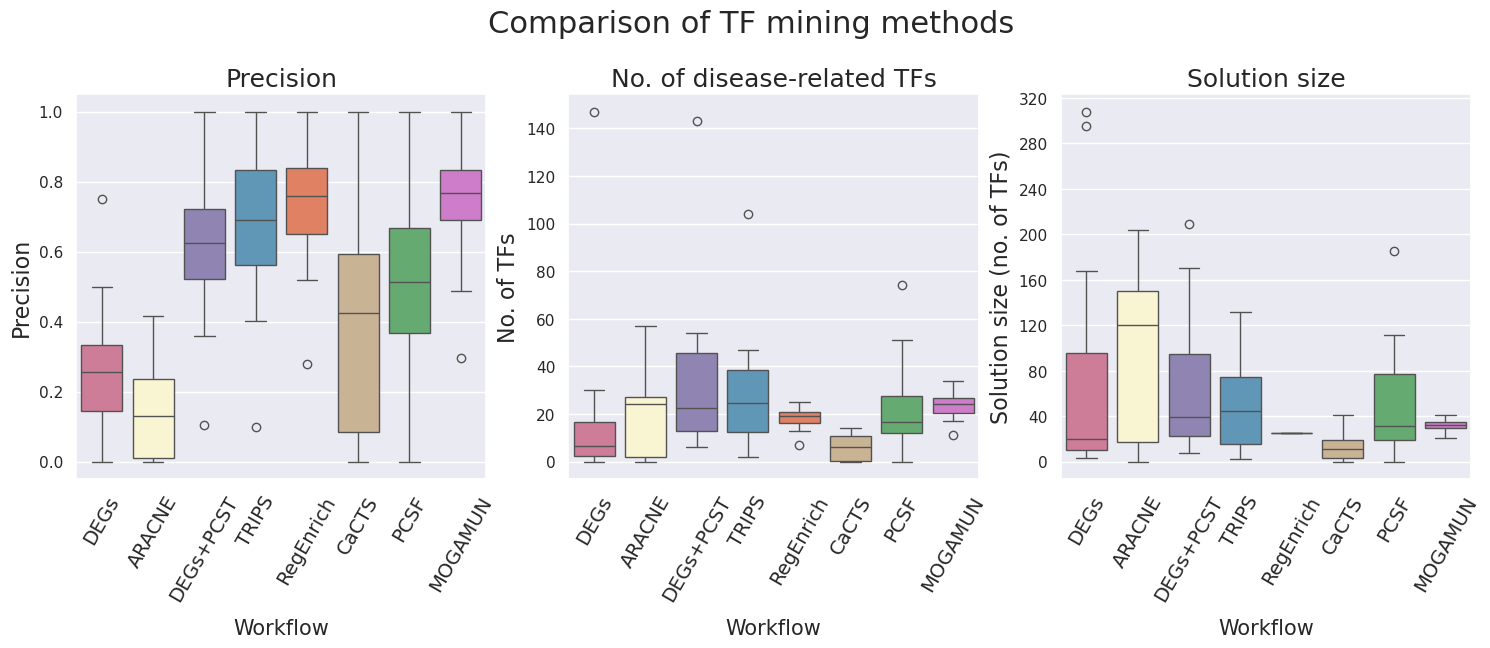

In [16]:
title = "Comparison of TF mining methods"
new_labels = ["DEGs","ARACNE","DEGs+PCST","TRIPS","RegEnrich","CaCTS","PCSF","MOGAMUN"]

my_colors = ["palevioletred",
             "lemonchiffon",
             dict_colors["degs_dorothea"],
             dict_colors["domino_dorothea"],
             dict_colors["regenrich_dorothea"],
             "tan",
             dict_colors["pcsf"],
            "orchid"]

filename = os.path.join(figures_folder_dor, "dorothea_comparison_tf_mining_methods.svg")
generate_plot(dict_precisions, dict_n_recovered, dict_soln_size, title=title, y=1.05,
              size_subtitle=18, xlabel="Workflow", my_colors = my_colors, figsize=(18,5),
             size_xlabel=15, size_xticklabel=14, rotation=60, size_ylabel=16, filename=None, new_labels=new_labels)

### Network perturbation: DEGs+PCST

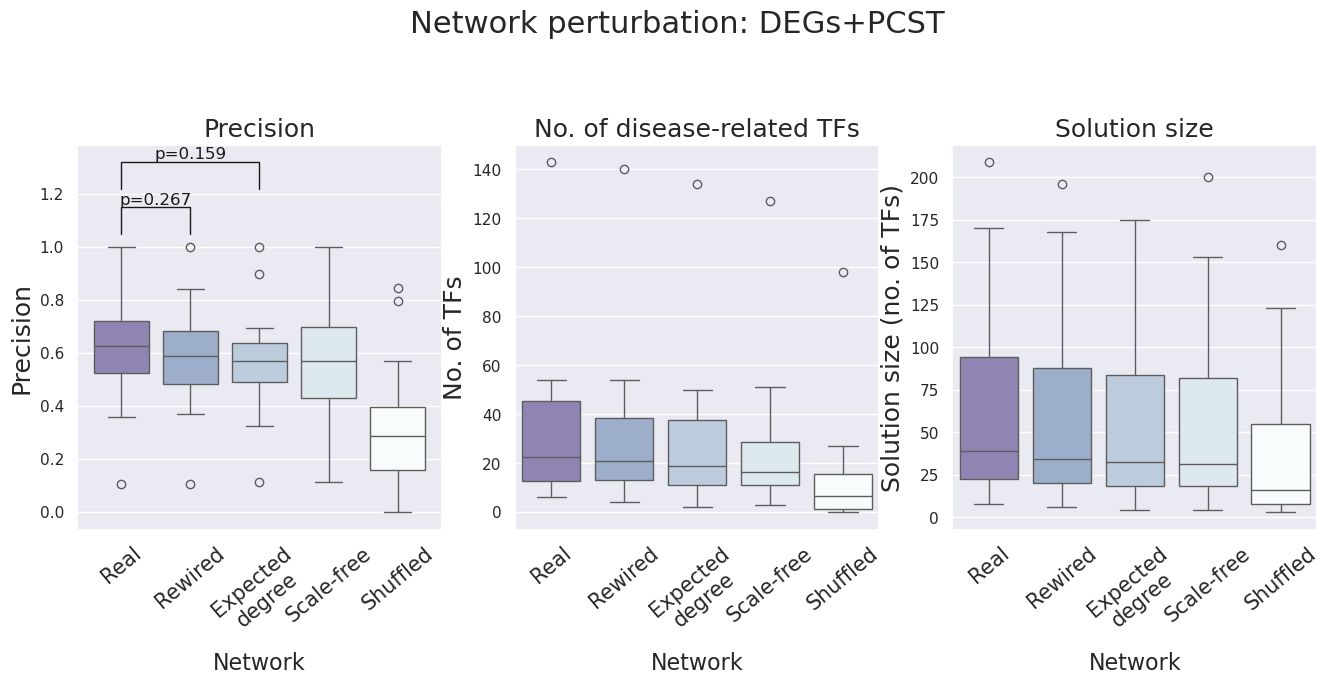

In [17]:
target_workflow = "degs_pcst"
title = "Network perturbation: DEGs+PCST"
dict_precision, dict_recall, dict_soln_size = network_perturbation(folder_degs_pcst, target_workflow, all_datasets, all_tfs=all_tfs,  
                                                                  dict_dataset_map=dict_dataset_map, folder_degs=folder_degs,
                                                                  title=title, gold_standard=dict_disease_genes_min1)

new_labels = ["Real","Rewired","Expected\ndegree", "Scale-free","Shuffled"]
    
filename = os.path.join(figures_folder_dor, "network_perturbation_degs_pcst.svg")
generate_plot_compare(dict_precision, dict_recall, dict_soln_size, target_workflow="degs_pcst",
              title=title,new_labels=new_labels, 
             filename=None, figsize=(16,5), y=1.15,
             size_xticklabel=15, size_ylabel=18, size_xlabel=16,
             xlabel = "Network", size_subtitle=18, my_colors=colors_degs_pcst, rotation=40)

### Network perturbation: TRIPS

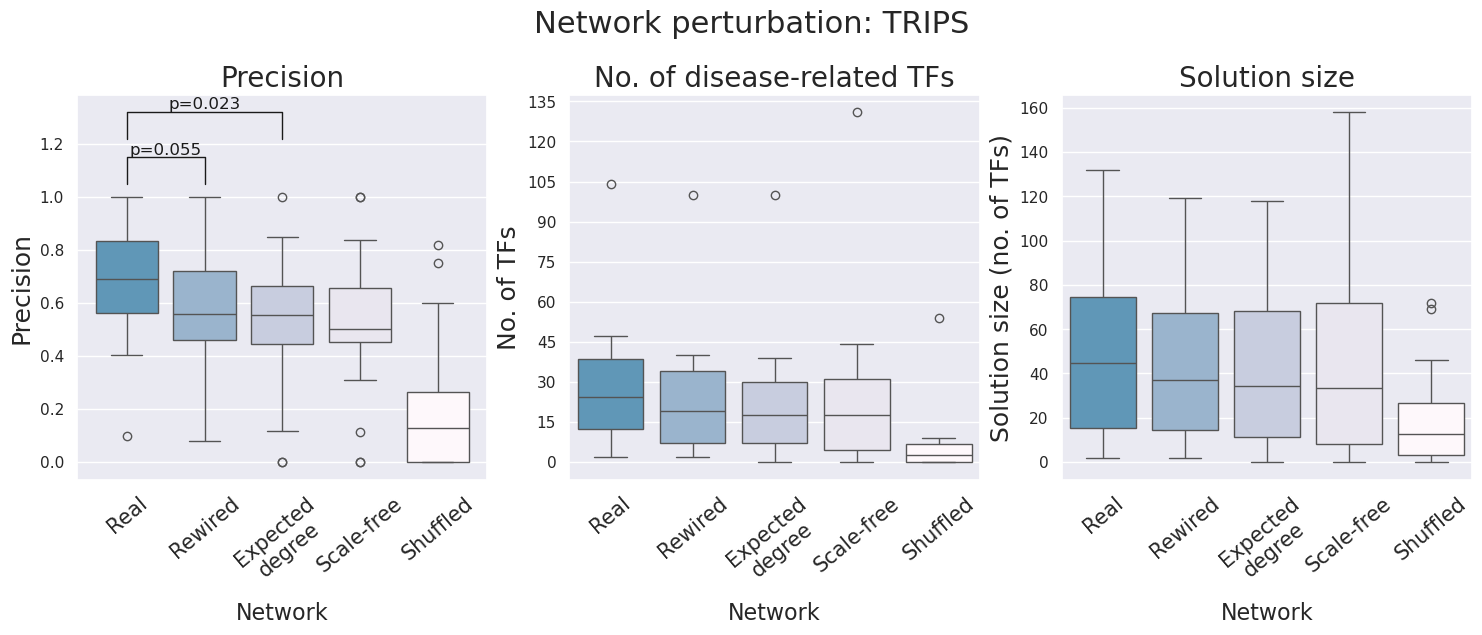

In [18]:
target_workflow = "trips"
title = "Network perturbation: TRIPS"
dict_precision, dict_recall, dict_soln_size = network_perturbation(folder_trips, target_workflow, all_datasets, all_tfs=all_tfs,  
                                                                  dict_dataset_map=dict_dataset_map, folder_degs=folder_degs,
                                                                  title=title, gold_standard=dict_disease_genes_min1)
new_labels = ["Real","Rewired","Expected\ndegree", "Scale-free","Shuffled"]

filename = os.path.join(figures_folder_dor, "network_perturbation_trips.svg")
generate_plot_compare(dict_precision, dict_recall, dict_soln_size, target_workflow="trips",
              title=title, new_labels=new_labels, 
             filename=filename, figsize=(18,5), y=1.05,
             size_xticklabel=15, size_ylabel=18, size_xlabel=16, rotation=40,
             xlabel = "Network", size_subtitle=20, my_colors=colors_trips)

### Network perturbation: RegEnrich

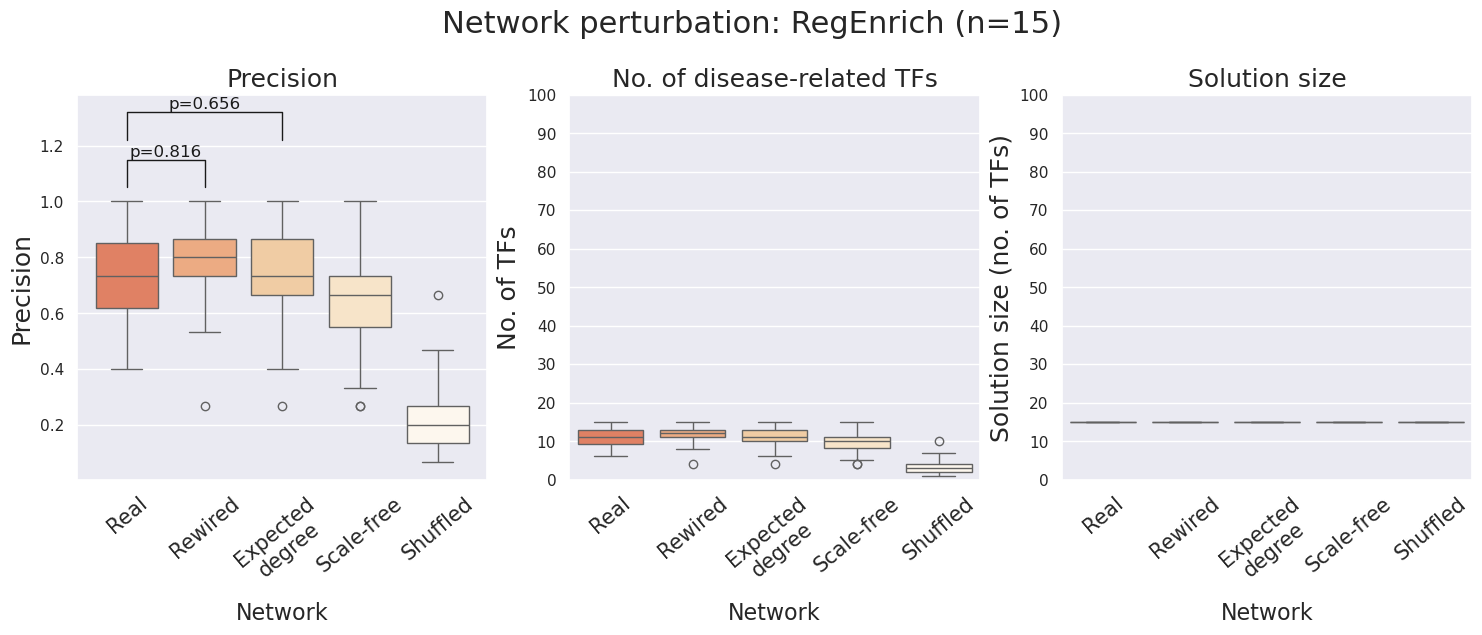

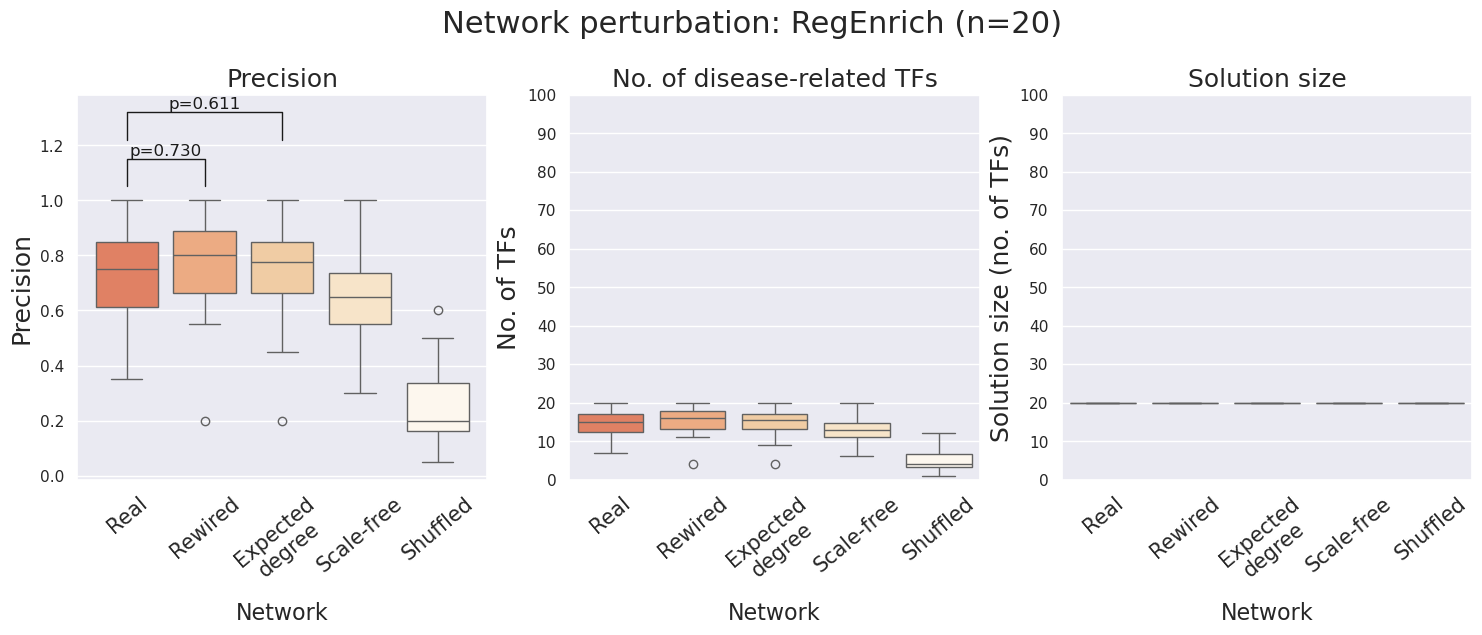

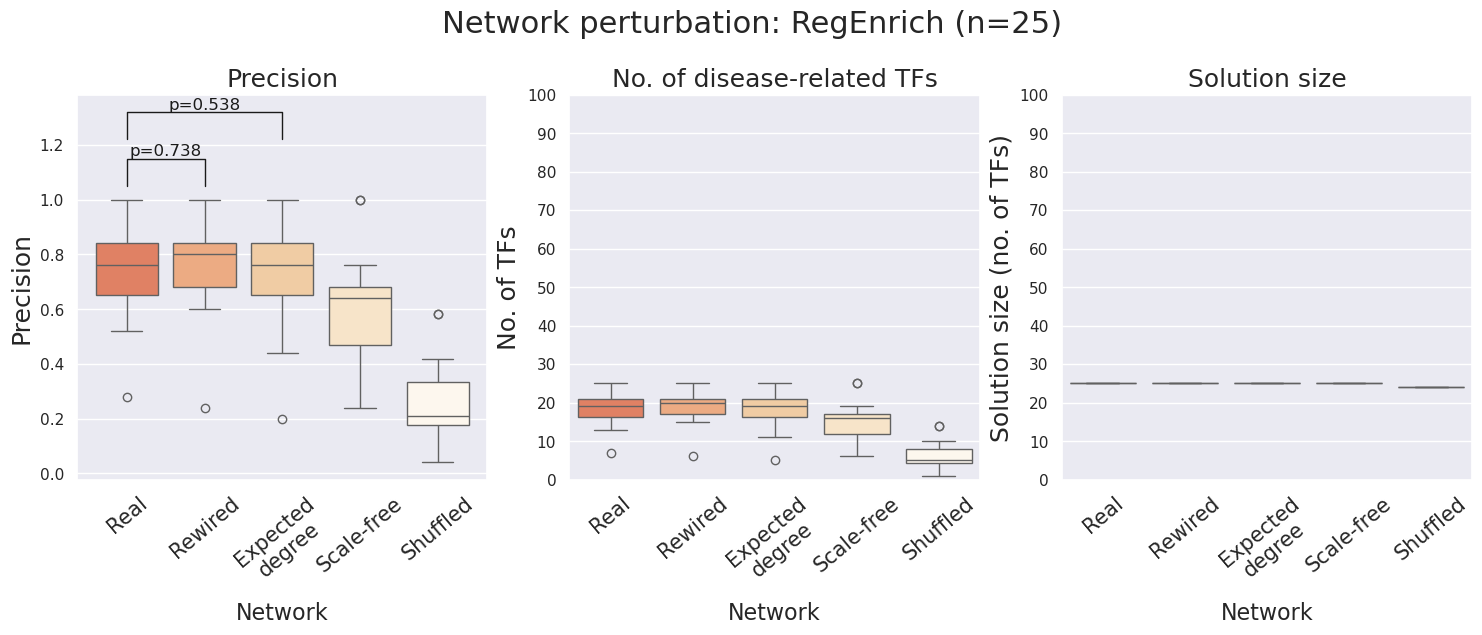

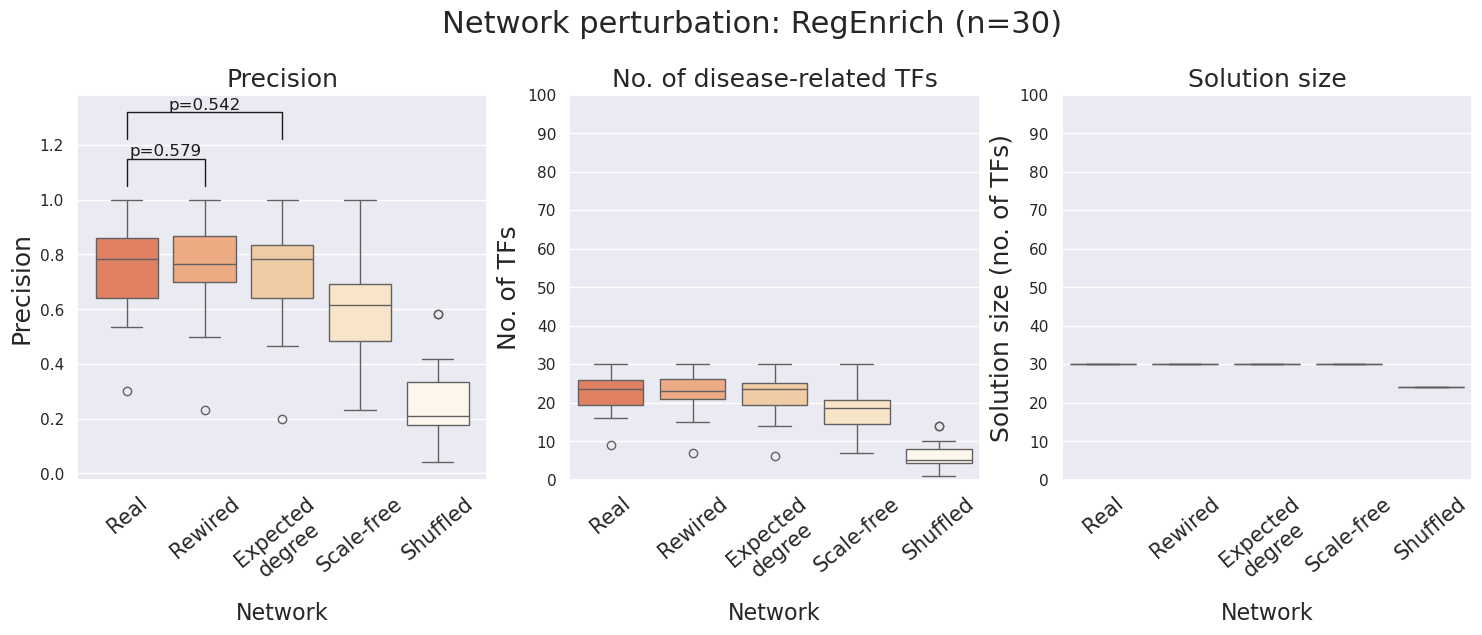

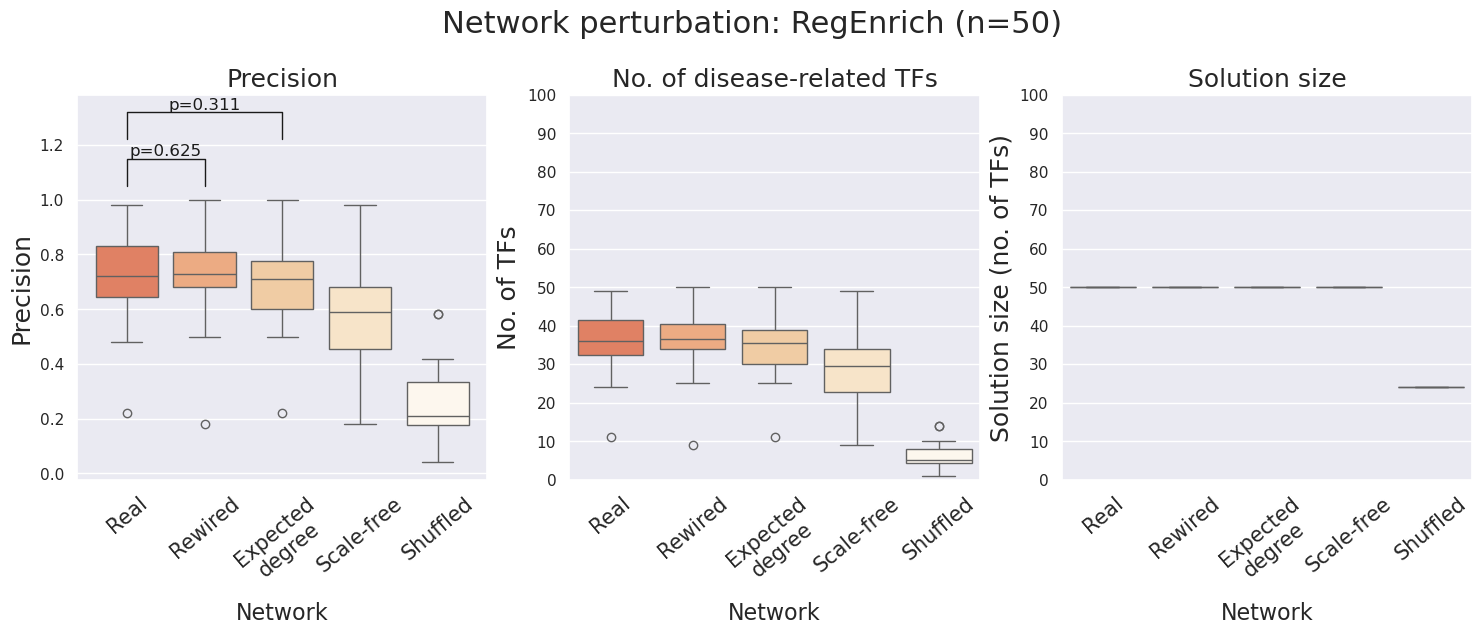

In [19]:
folder_regenrich_all = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_regenrich/"
target_workflow = "regenrich"

for n_top_reg in [15,20,25,30,50]:
    
    dict_precision, dict_recall, dict_soln_size = network_perturbation(folder_regenrich_all, target_workflow, all_datasets, all_tfs=all_tfs, 
                                                                          dict_dataset_map=dict_dataset_map, folder_degs=folder_degs, 
                                                                          title=title, gold_standard=dict_disease_genes_min1, N=n_top_reg)
    new_labels = ["Real","Rewired","Expected\ndegree", "Scale-free","Shuffled"]

    title = "Network perturbation: RegEnrich (n={})".format(n_top_reg)
    filename = os.path.join(figures_folder_dor, "network_perturbation_regenrich_n{}.svg".format(n_top_reg))
    generate_plot_compare(dict_precision, dict_recall, dict_soln_size, target_workflow="regenrich",
                  title=title, new_labels=new_labels,
                 filename=filename, figsize=(18,5), y=1.05,
                 size_xticklabel=15, size_ylabel=18, size_xlabel=16, 
                 xlabel = "Network", size_subtitle=18, my_colors=colors_regenrich, rotation=40, workflow="regenrich", ymax=100)

### Network perturbation: PCSF

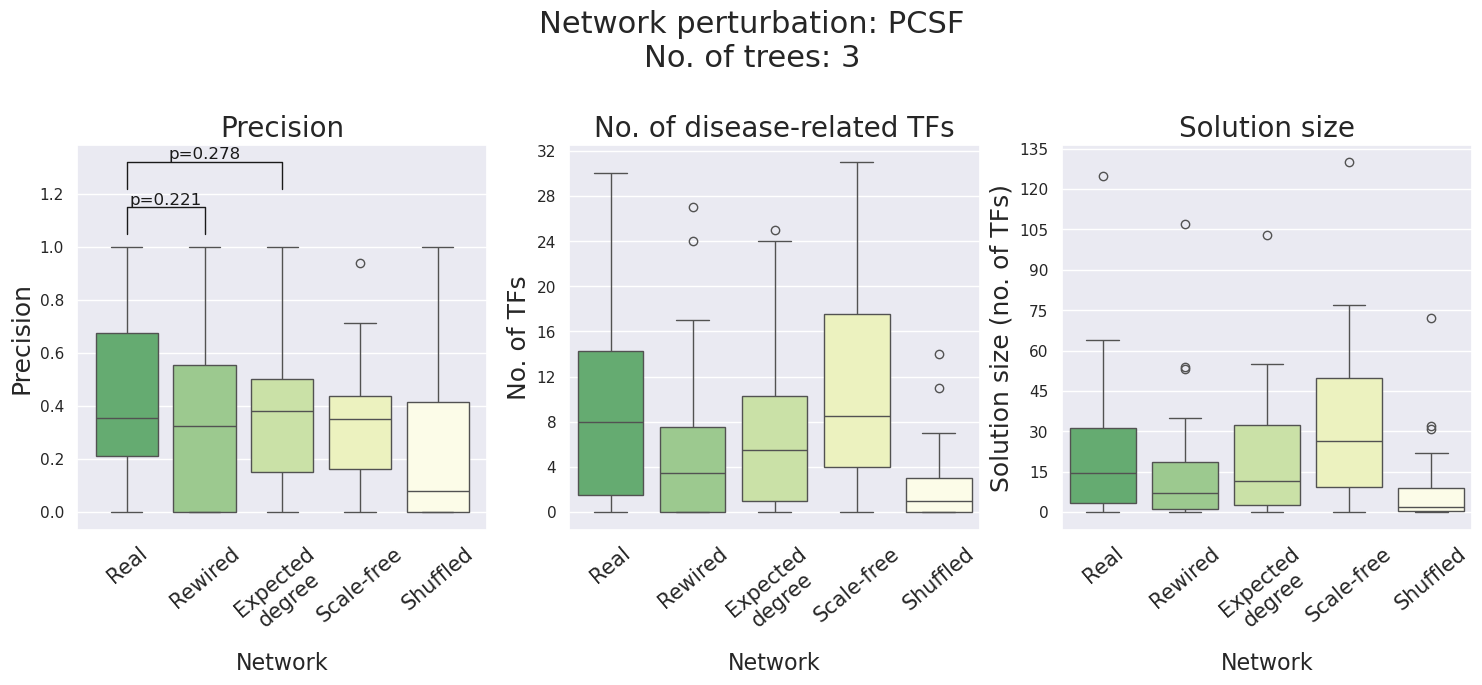

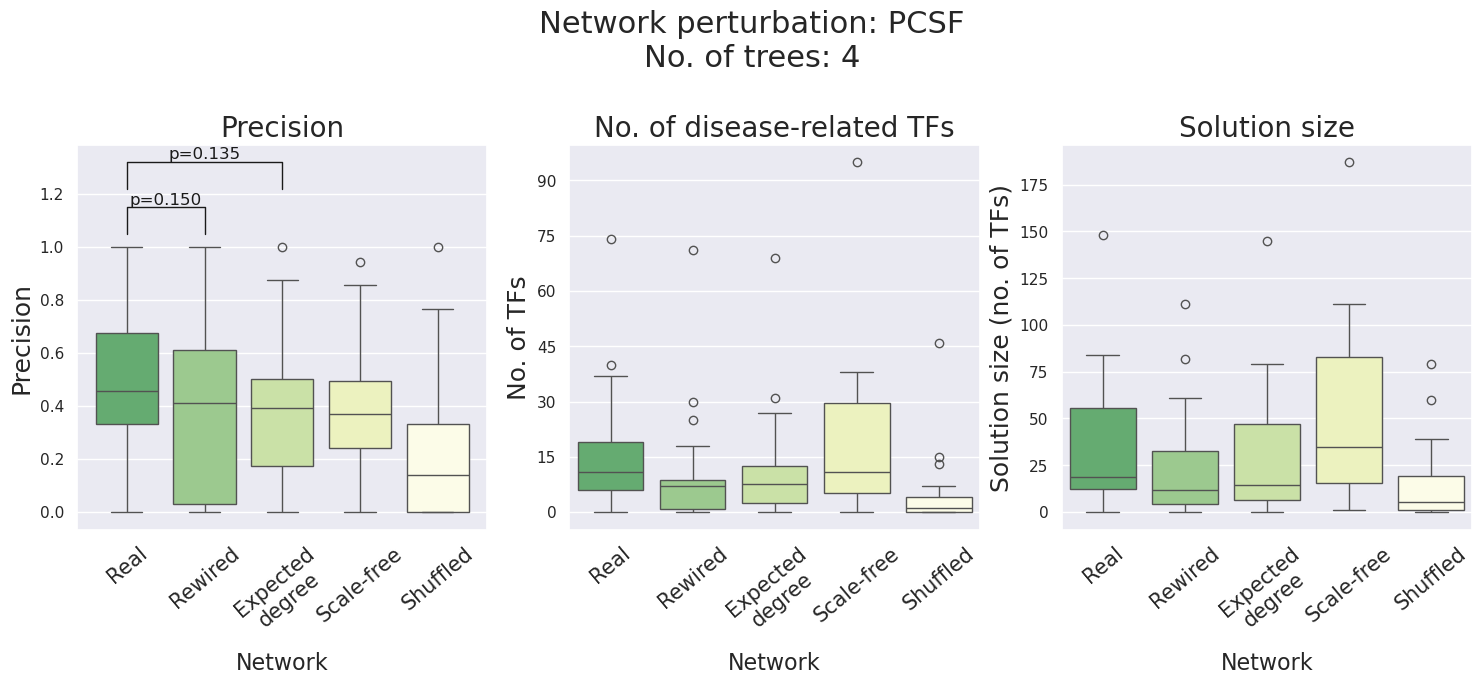

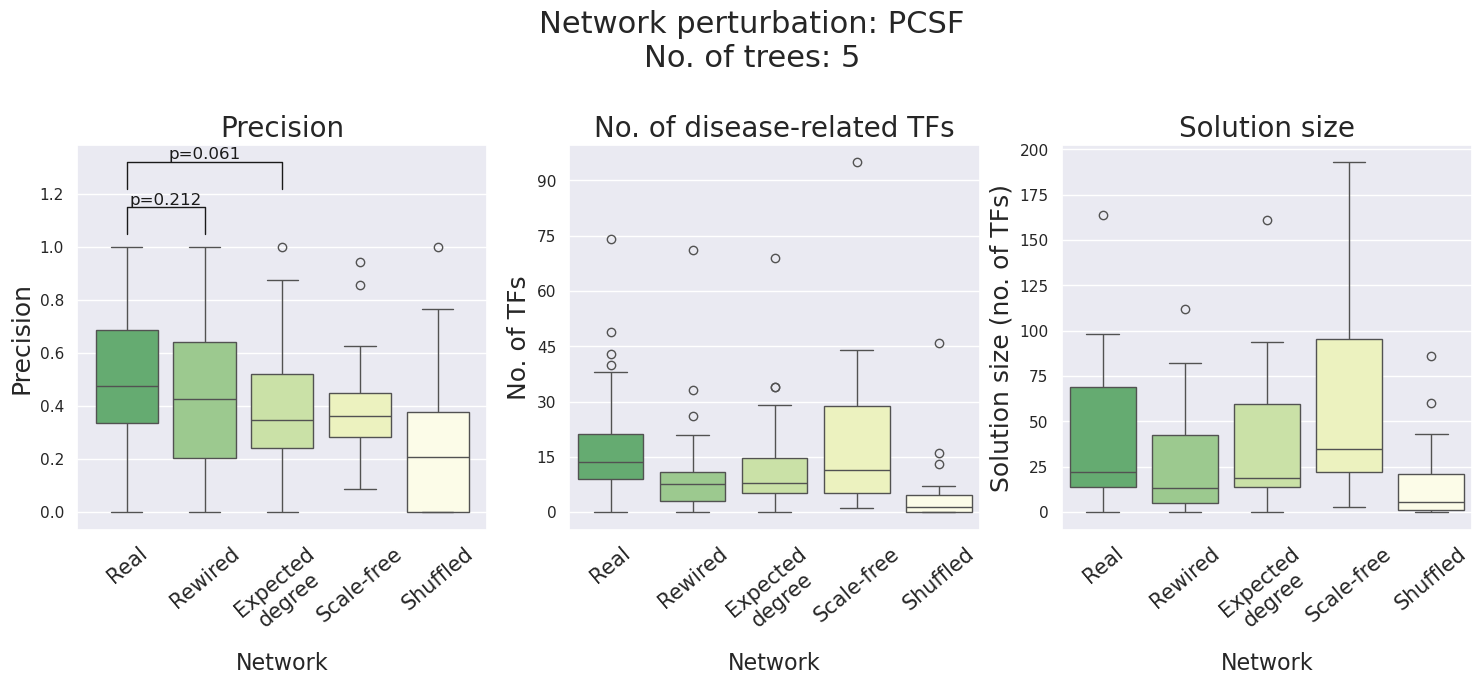

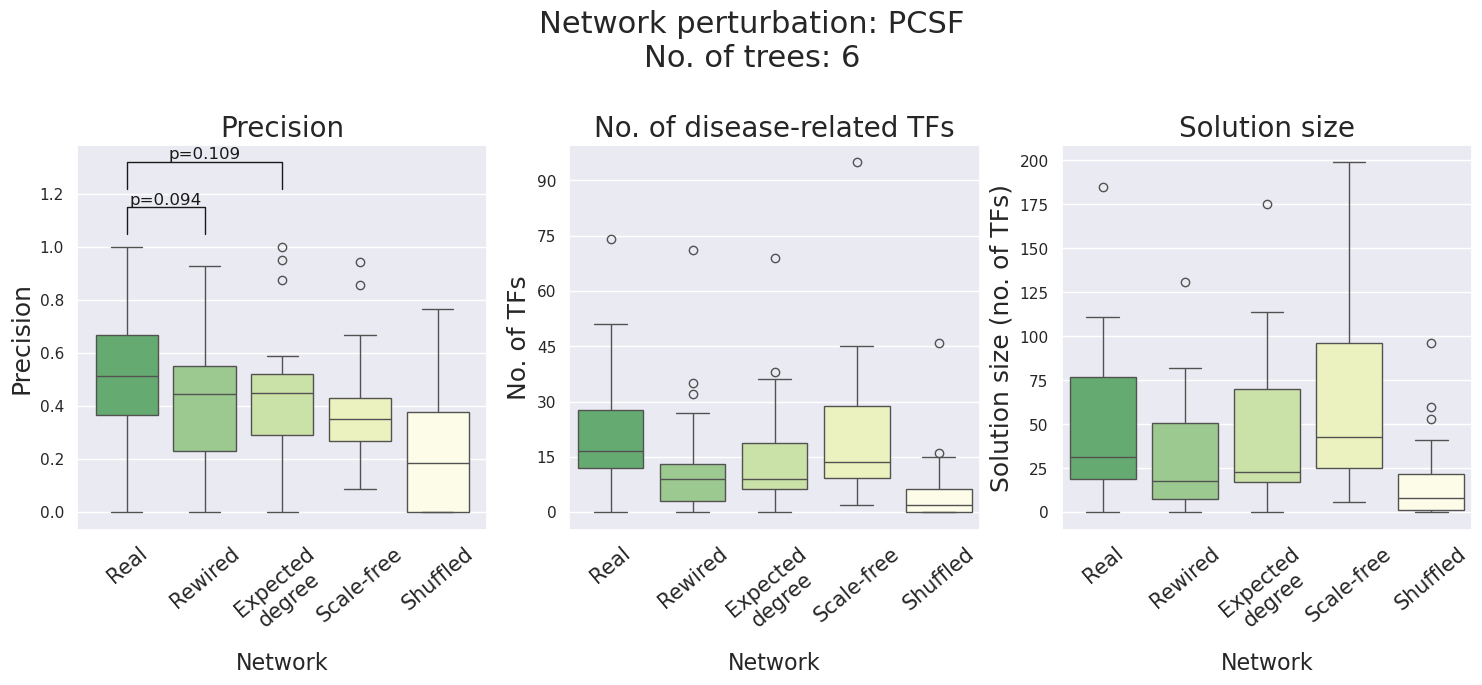

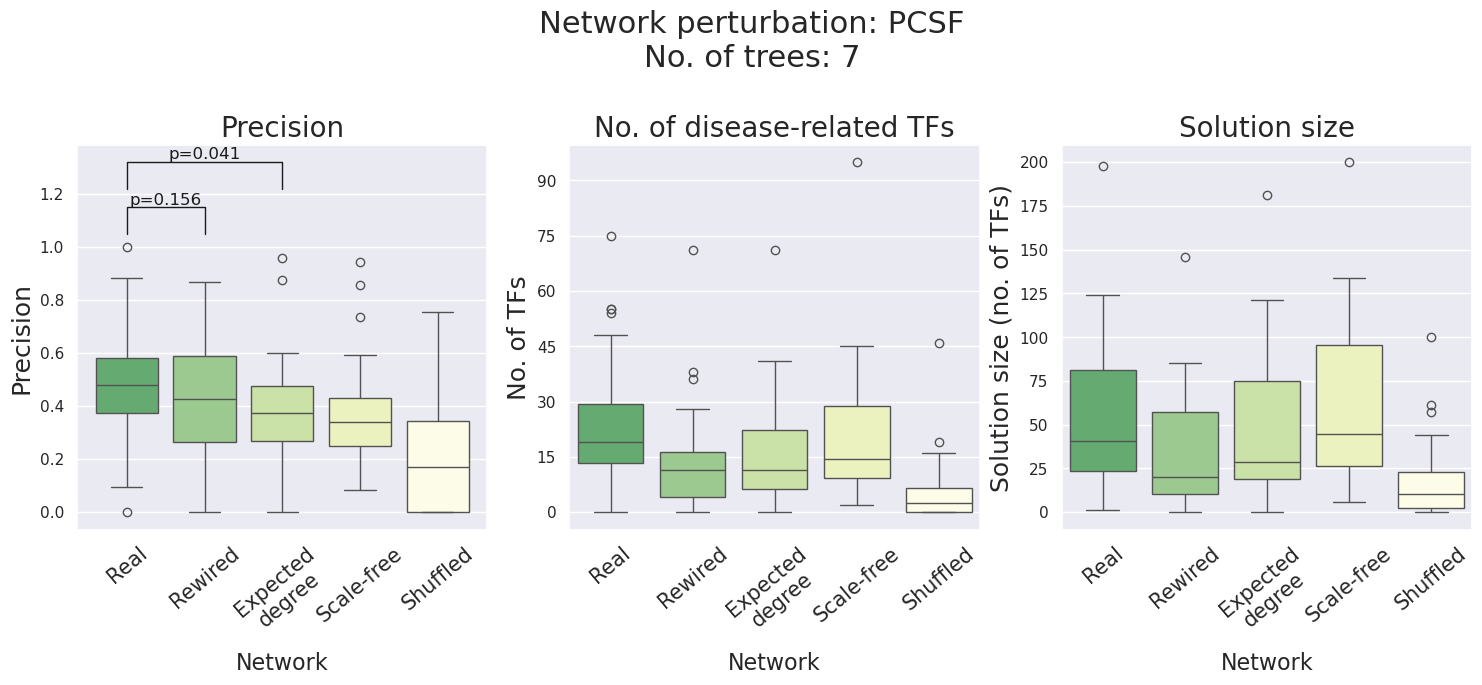

In [20]:
folder_pcsf_all = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_pcsf/2/"

n_mechanisms = [3,4,5,6,7]
target_workflow = "pcsf"

for n_mech in n_mechanisms:
    
    title = "Network perturbation: PCSF\nNo. of trees: {}".format(n_mech)
    dict_precision, dict_recall, dict_soln_size = network_perturbation(folder_pcsf_all, target_workflow, all_datasets, all_tfs=all_tfs,  
                                                                          dict_dataset_map=dict_dataset_map, folder_degs=folder_degs, 
                                                                          title=title, gold_standard=dict_disease_genes_min1, n_mech=n_mech)
    
    new_labels = ["Real","Rewired","Expected\ndegree", "Scale-free","Shuffled"]
    title = "Network perturbation: PCSF\nNo. of trees: {}".format(n_mech)

    filename = os.path.join(figures_folder_dor, "network_perturbation_pcsf_multip2_nmech{}.svg".format(n_mech))
    generate_plot_compare(dict_precision, dict_recall, dict_soln_size, target_workflow="pcsf",
                  title=title, new_labels=new_labels, 
                 filename=filename, figsize=(18,5), y=1.15,
                 size_xticklabel=15, size_ylabel=18, size_xlabel=16,
                 xlabel = "Network", size_subtitle=20, my_colors=colors_pcsf, rotation=40)

### Network perturbation: MOGAMUN

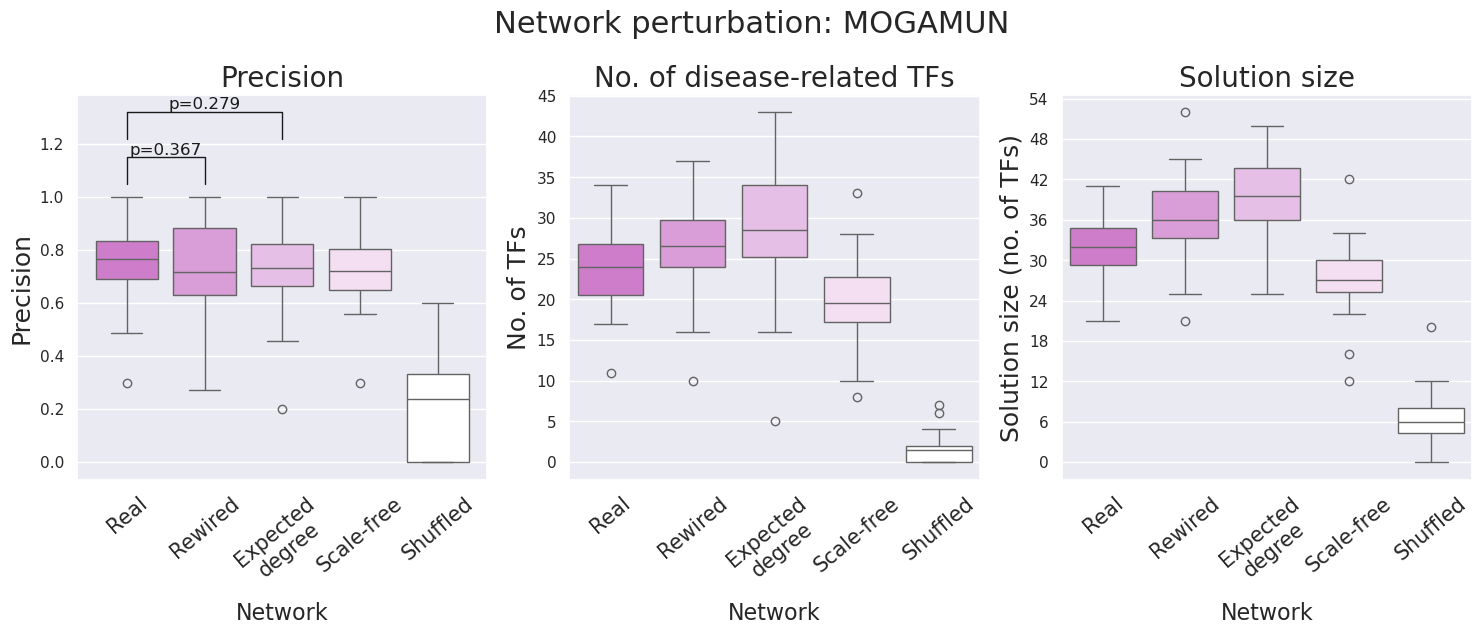

In [21]:
target_workflow = "mogamun"

folder_mogamun_all = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_mogamun/"
title = "Network perturbation: MOGAMUN"
dict_precision, dict_recall, dict_soln_size = network_perturbation(folder_mogamun_all, target_workflow, all_datasets, all_tfs=all_tfs, 
                                                                      dict_dataset_map=dict_dataset_map, folder_degs=folder_degs, 
                                                                      title=title, gold_standard=dict_disease_genes_min1)

new_labels = ["Real","Rewired","Expected\ndegree", "Scale-free","Shuffled"]

filename = os.path.join(figures_folder_dor, "network_perturbation_mogamun.svg")
generate_plot_compare(dict_precision, dict_recall, dict_soln_size, target_workflow = "mogamun",
              title=title, new_labels=new_labels, 
             filename=filename, figsize=(18,5), y=1.05,
             size_xticklabel=15, size_ylabel=18, size_xlabel=16,
             xlabel = "Network", size_subtitle=20, my_colors=colors_mogamun, rotation=40)

# EXTRI

In [22]:
folder_trips = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_trips"
folder_pcsf = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_pcsf/2/PCSF"
folder_regenrich = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_regenrich/REGENRICH"
folder_mogamun = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_mogamun/REAL"
folder_degs_pcst = r"/data2/home/giga/TRIPS_results/ZENODO/DOROTHEA/results_degs_pcst/"

In [23]:
folder_trips_extri = r"/data2/home/giga/TRIPS_results/ZENODO/EXTRI/results_trips"
folder_pcsf_extri = r"/data2/home/giga/TRIPS_results/ZENODO/EXTRI/results_pcsf/2/PCSF"
folder_regenrich_extri = r"/data2/home/giga/TRIPS_results/ZENODO/EXTRI/results_regenrich/REGENRICH"
folder_mogamun_extri = r"/data2/home/giga/TRIPS_results/ZENODO/EXTRI/results_mogamun/REAL/"

## Comparison

In [ ]:
workflows = ["trips","trips_extri","regenrich","regenrich_extri","pcsf","pcsf_extri","mogamun","mogamun_extri"]

lfc_thresh = 1.0
pval_thresh = 0.05
n_regenrich = 25
gold_standard = dict(dict_disease_genes_min1)

dict_precisions = {k:[] for k in workflows}
dict_n_recovered = {k:[] for k in workflows}
dict_soln_size = {k:[] for k in workflows}

for dataset in all_datasets:

    # ============Load the results per dataset================

    print("Processing dataset:", dataset)
    doid = dict_dataset_map[dataset]["DOID"]
    disease_genes = gold_standard[doid]
    disease_tfs = list(set(disease_genes).intersection(set(all_tfs)))

    for workflow in workflows:
        soln = []

        file_degs = os.path.join(folder_degs, "{}_signatureData.csv".format(dataset)) 
        df = pd.read_csv(file_degs)
        df_sub = df[df["FDR_adjusted_P.value"] < pval_thresh]
        df_sub = df_sub[abs(df_sub["Log_FoldChange"]) > lfc_thresh]
        degs = list(df_sub["Gene_symbol"])

        if workflow == "degs":
            soln = list(set(degs))

        elif workflow == "degs_pcst":
            soln = extract_degs_pcst_results(folder_degs_pcst, dataset)

        elif workflow == "diamond_pcst":
            soln = extract_diamond_pcst_results(folder_diam_pcst, dataset, directed=directed)

        elif workflow in ["trips","trips_extri"]:
            if workflow == "trips":
                target_folder = os.path.join(folder_trips, dataset)
            elif workflow == "trips_extri":
                target_folder = os.path.join(folder_trips_extri, dataset)
            soln = load_combined_solutions(target_folder, dataset, directed=False)

        elif workflow in ["pcsf","pcsf_extri"]:
            if workflow == "pcsf":
                file_soln = os.path.join(folder_pcsf, "{}_edges_3.txt".format(dataset))
            elif workflow == "pcsf_extri":
                file_soln = os.path.join(folder_pcsf_extri, "{}_edges_3.txt".format(dataset))
            soln = extract_pcsf_results(file_soln) 

        elif workflow in ["regenrich","regenrich_extri"]:
            if workflow == "regenrich":
                soln = extract_regenrich_results(folder_regenrich, dataset, sep="\t", n_top_reg=n_regenrich)  
            elif workflow == "regenrich_extri":
                soln = extract_regenrich_results(folder_regenrich_extri, dataset, sep="\t", n_top_reg=n_regenrich)  

        elif workflow in ["mogamun","mogamun_extri"]:
            if workflow == "mogamun":
                folder_sub = glob.glob(os.path.join(folder_mogamun, dataset, "Experiment_*".format(dataset)))
                if len(folder_sub) == 1:
                    file = os.path.join(folder_sub[0], "A_ALL_FILTERED_INTERACTIONS_CYTOSCAPE.csv")
                    if os.path.exists(file):
                        soln = extract_mogamun_results(file)
            elif workflow == "mogamun_extri":
                folder_sub = glob.glob(os.path.join(folder_mogamun_extri, dataset, "Experiment_*".format(dataset)))
                if len(folder_sub) == 1:
                    file = os.path.join(folder_sub[0], "A_ALL_FILTERED_INTERACTIONS_CYTOSCAPE.csv")
                    if os.path.exists(file):
                        soln = extract_mogamun_results(file)
                        
        elif workflow == "cacts":
            file = os.path.join(folder_cacts, "{}_filtered_top10.txt".format(dataset))
            soln = extract_cacts_results(file)

        # Get only the TFs
        soln = list(set(soln).intersection(set(all_tfs)))
        soln = list(set(soln))
        
        # ============UPDATE THE DICTIONARIES===============
        common_genes = list(set(soln).intersection(set(disease_tfs)))
        dict_precisions[workflow].append(calculate_precision(soln, disease_tfs))
        dict_n_recovered[workflow].append(len(common_genes))
        dict_soln_size[workflow].append(len(soln))

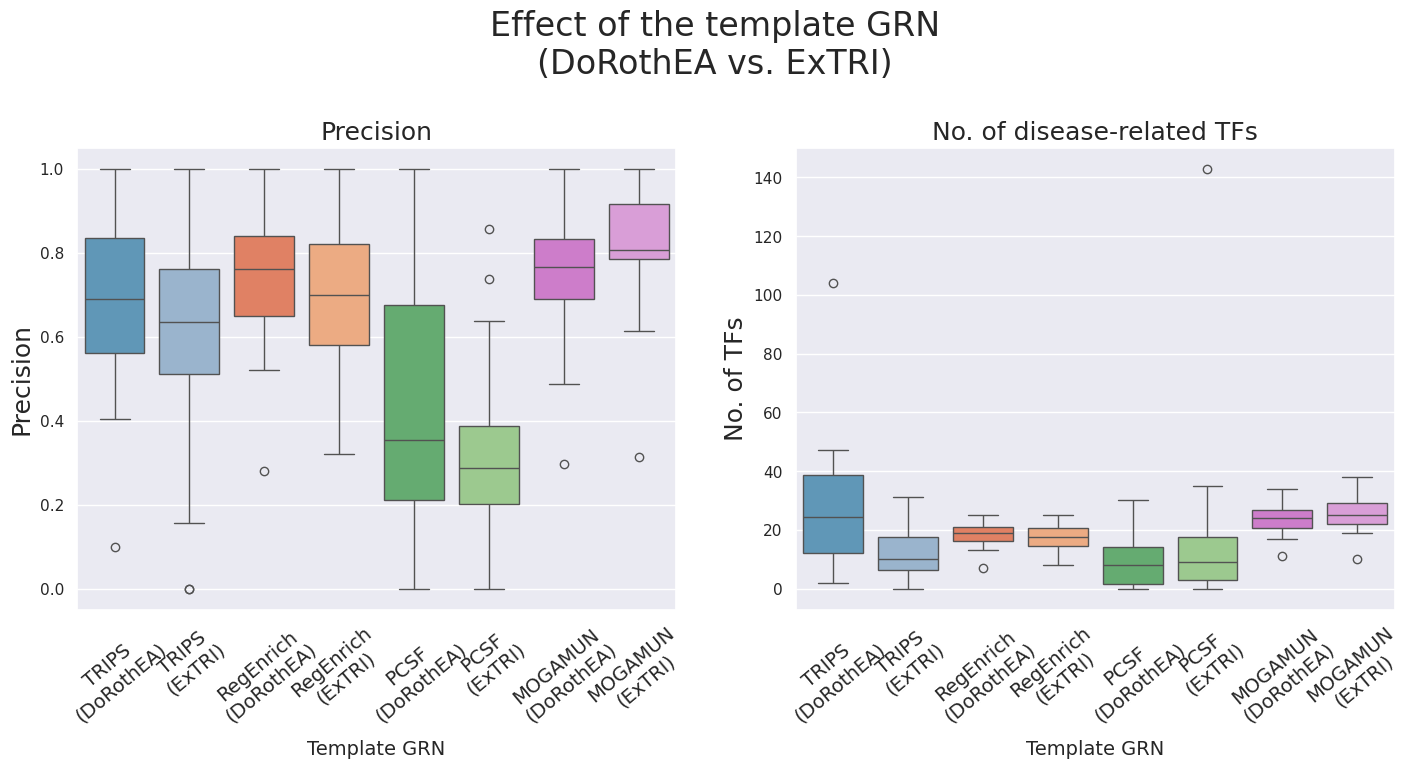

In [27]:
title = "Effect of the template GRN\n(DoRothEA vs. ExTRI)"

new_labels = ["TRIPS\n(DoRothEA)","TRIPS\n(ExTRI)",
              "RegEnrich\n(DoRothEA)","RegEnrich\n(ExTRI)",
              "PCSF\n(DoRothEA)","PCSF\n(ExTRI)",
             "MOGAMUN\n(DoRothEA)","MOGAMUN\n(ExTRI)"]

my_colors = [ dict_colors["domino_dorothea"], dict_colors_int["domino_dorothea"],
             dict_colors["regenrich_dorothea"], dict_colors_int["regenrich_dorothea"],
             dict_colors["pcsf"], dict_colors_int["pcsf"],
             dict_colors["mogamun"], dict_colors_int["mogamun"]]

workflows = ["trips","trips_extri","regenrich","regenrich_extri","pcsf","pcsf_extri","mogamun","mogamun_extri"]
filename = os.path.join(figures_folder_extri, "extri_comparison_tf_mining_pvals.png")
generate_plot_compare_extri(dict_precisions, dict_n_recovered, dict_soln_size, workflows=workflows, title=title, y=1.11, fontsize=24,
              size_subtitle=18, xlabel="Template GRN", my_colors = my_colors, figsize=(17,6),
             size_xlabel=14, size_xticklabel=14, rotation=40, size_ylabel=18, filename=filename, new_labels=new_labels)

## Network perturbation: TRIPS

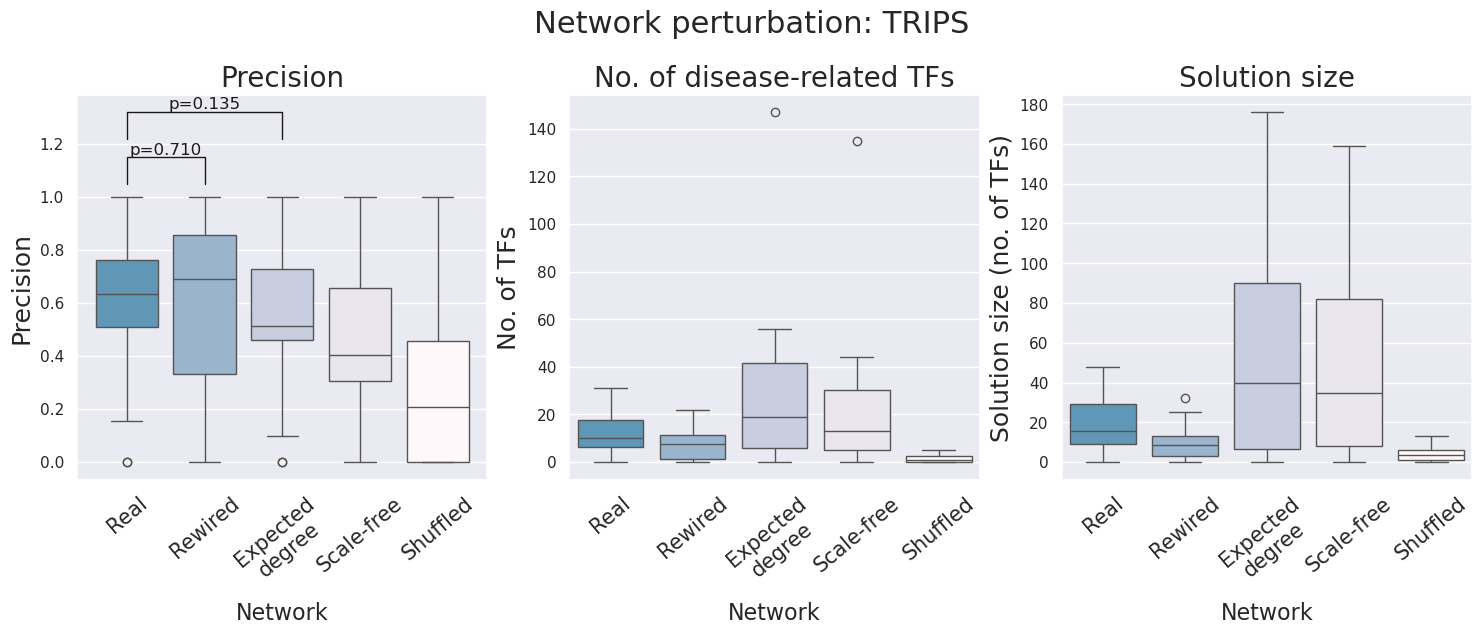

In [30]:
target_workflow = "trips"

title = "Network perturbation: TRIPS"
subfolder = r"/data2/home/giga/TRIPS_results/ZENODO/EXTRI/results_trips/"
dict_precision, dict_recall, dict_soln_size = network_perturbation(subfolder, target_workflow, all_datasets, all_tfs=all_tfs, 
                                                                  dict_dataset_map=dict_dataset_map, folder_degs=folder_degs,
                                                                  title=title, gold_standard=dict_disease_genes_min1)

new_labels = ["Real","Rewired","Expected\ndegree", "Scale-free","Shuffled"]

filename = os.path.join(figures_folder_extri, "network_perturbation_trips.svg")
generate_plot_compare(dict_precision, dict_recall, dict_soln_size, target_workflow="trips",
              title=title, new_labels=new_labels, 
             filename=filename, figsize=(18,5), y=1.05,
             size_xticklabel=15, size_ylabel=18, size_xlabel=16, rotation=40,
             xlabel = "Network", size_subtitle=20, my_colors=colors_trips)

## Network perturbation: RegEnrich

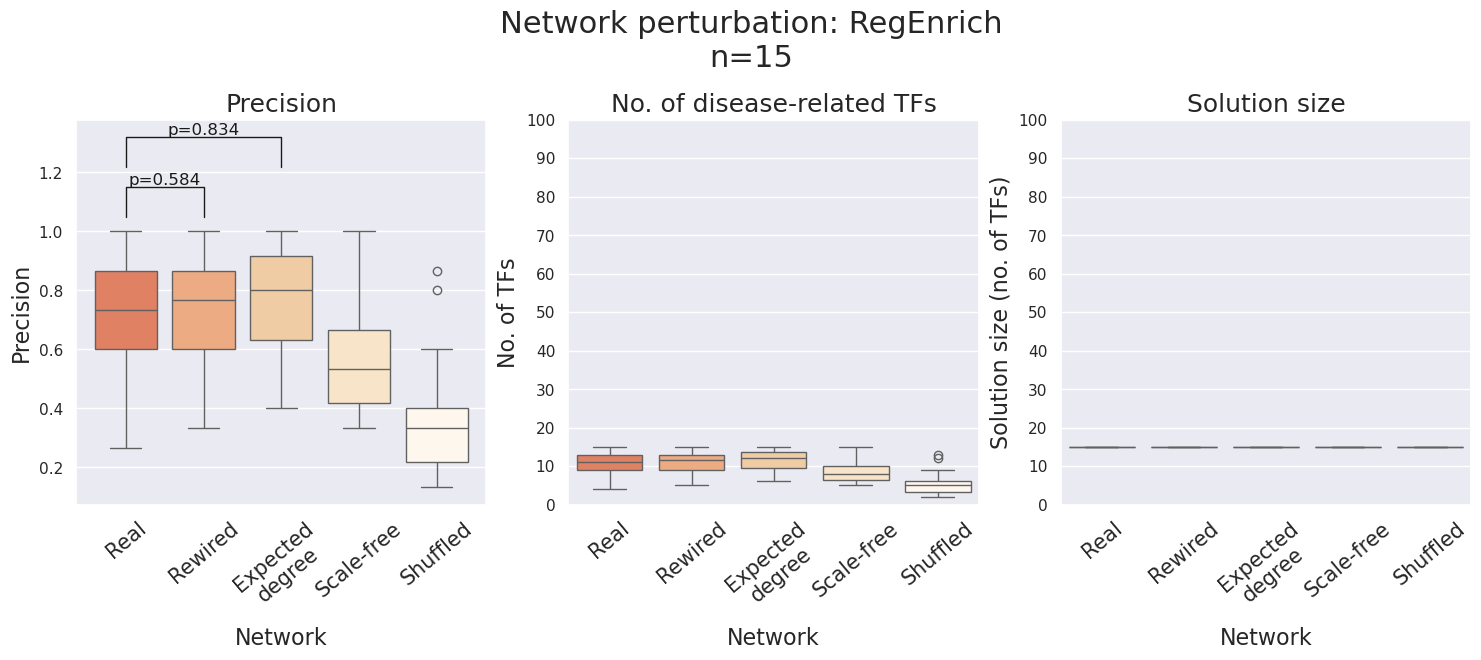

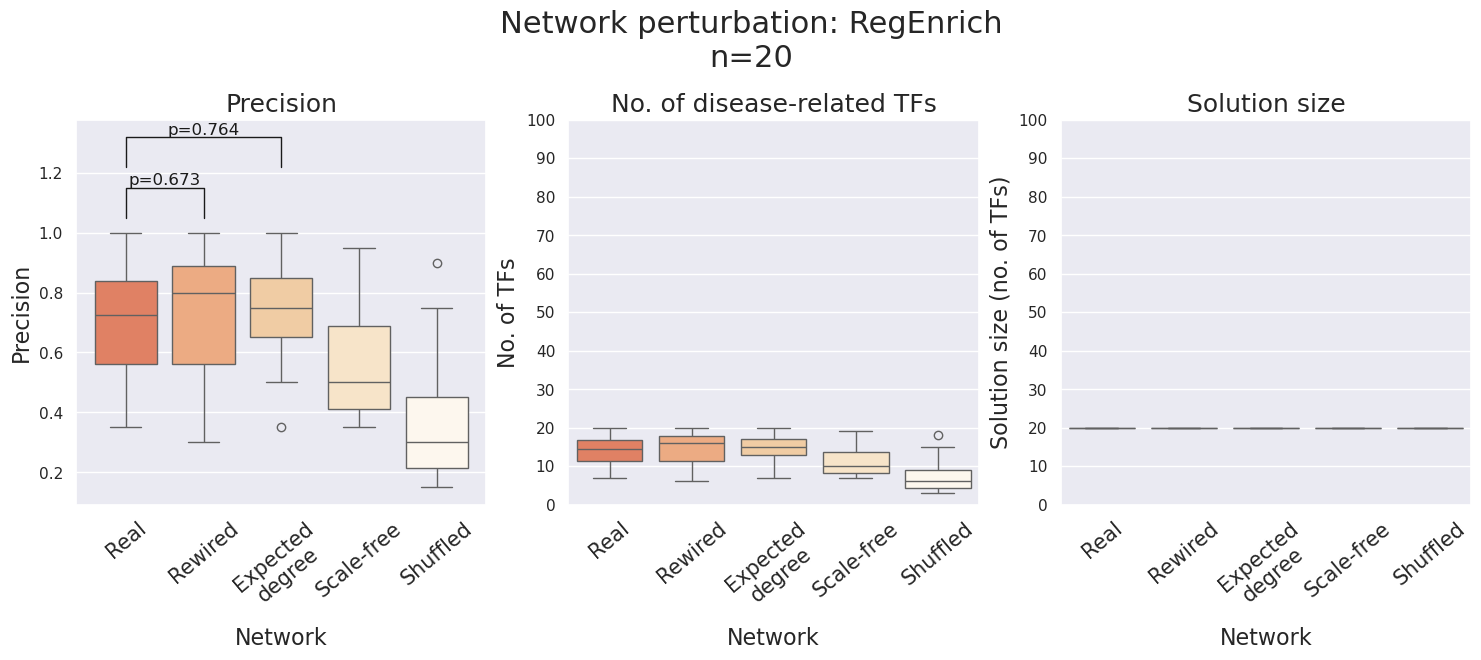

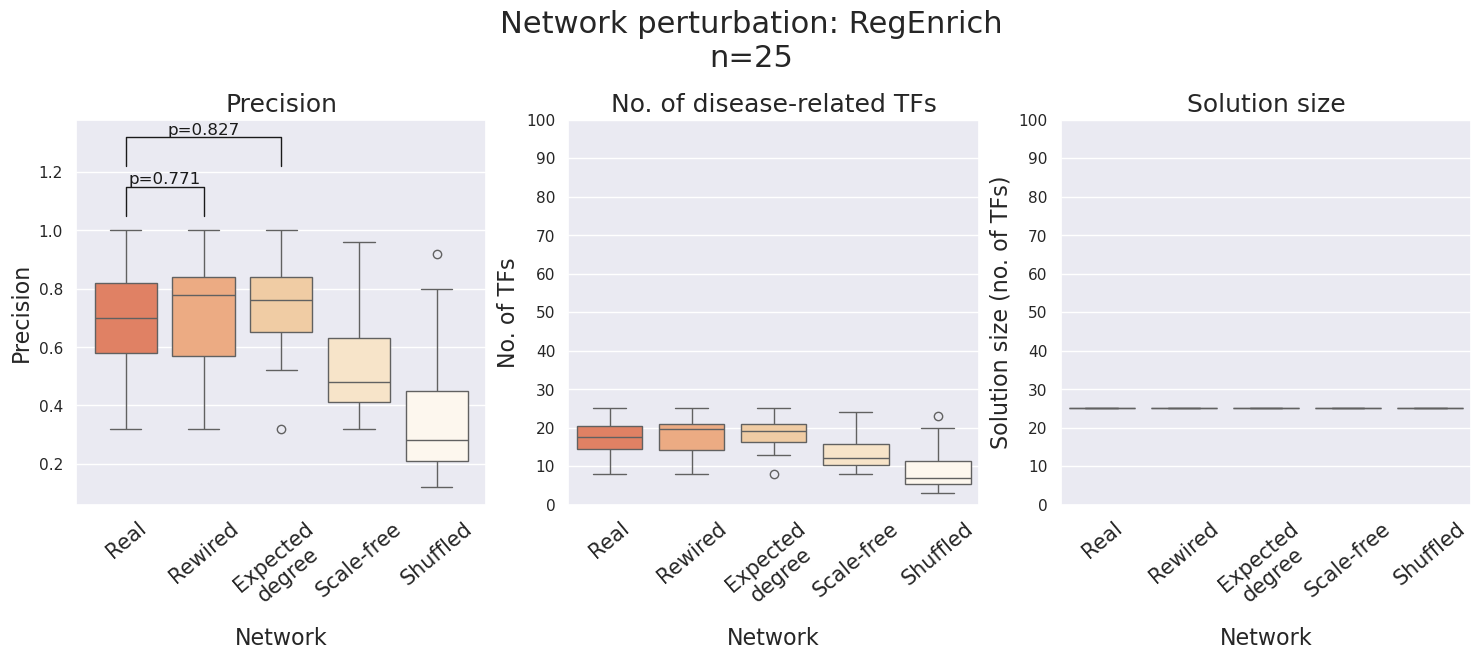

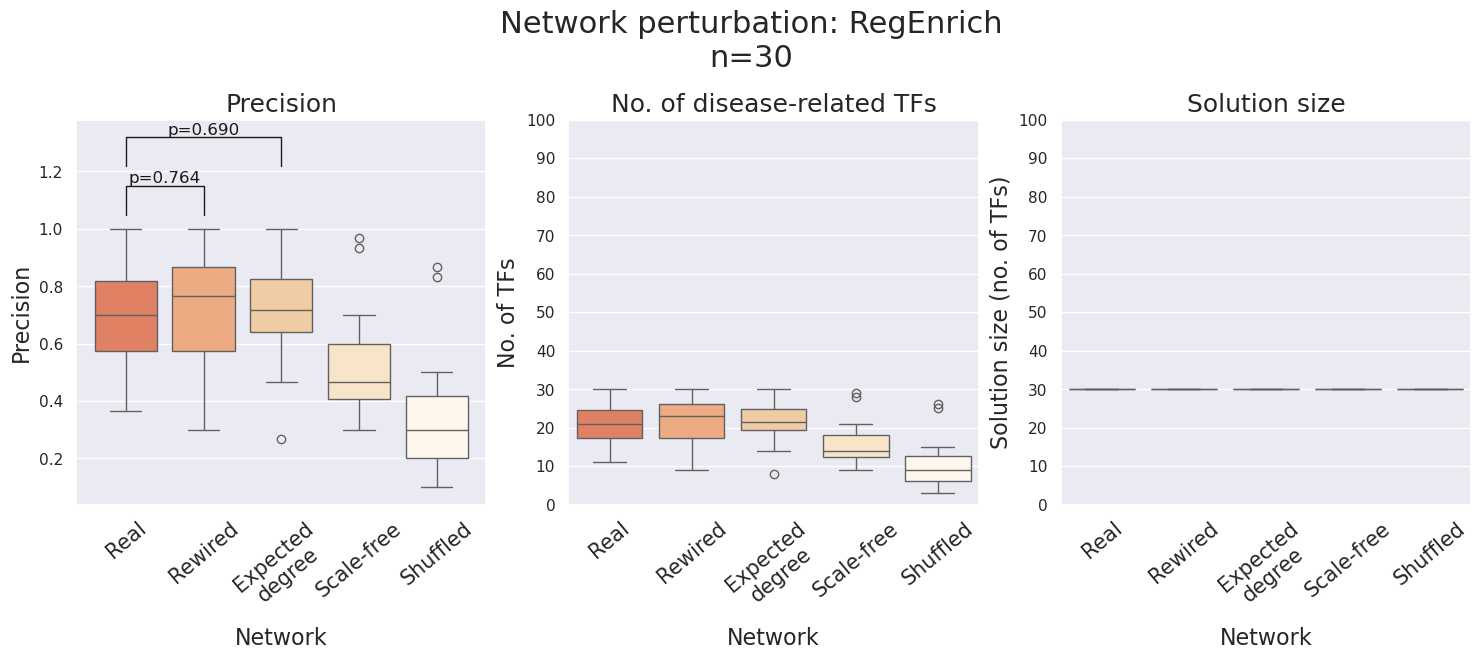

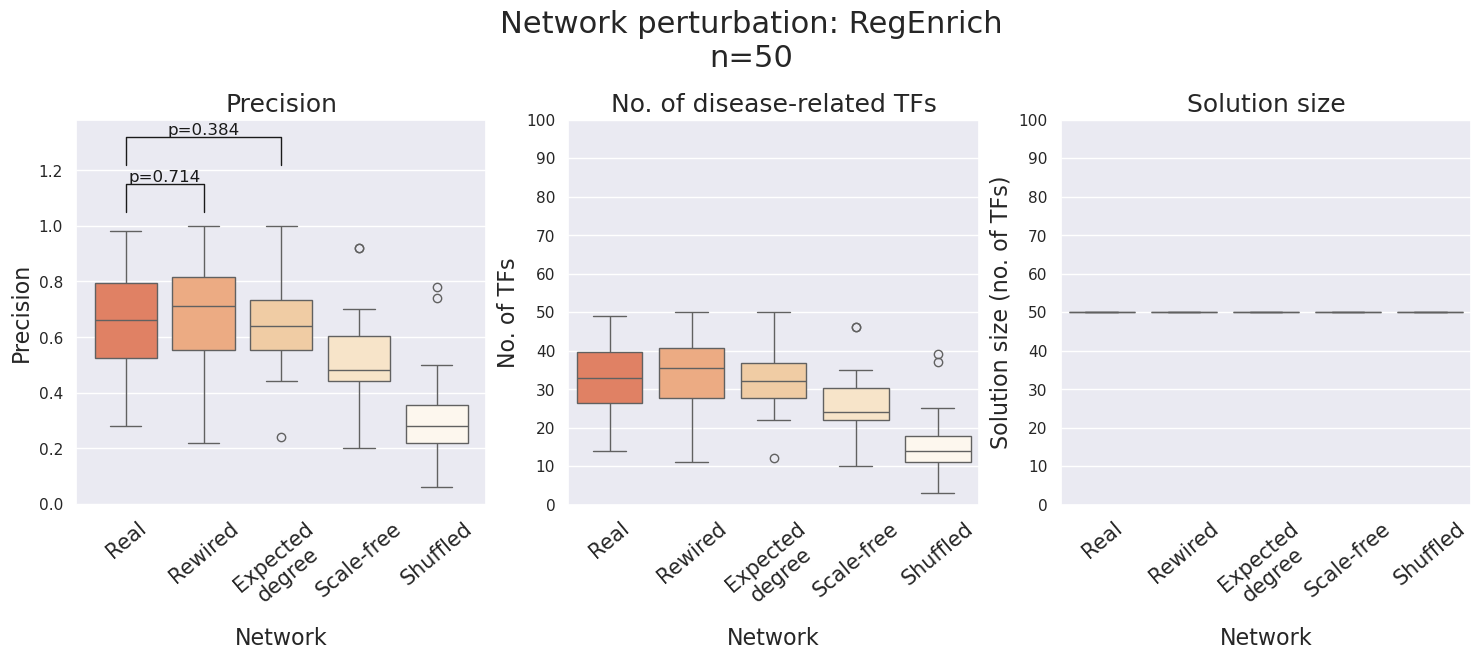

In [31]:
folder_regenrich_extri_all = '/data2/home/giga/TRIPS_results/ZENODO/EXTRI/results_regenrich'
target_workflow = "regenrich"

for n_top_reg in [15,20,25,30,50]:

    dict_precisions, dict_recall, dict_soln_size = network_perturbation(folder_regenrich_extri_all, target_workflow, all_datasets, all_tfs=all_tfs, 
                                                                          dict_dataset_map=dict_dataset_map, folder_degs=folder_degs, 
                                                                          title=title, gold_standard=dict_disease_genes_min1, N=n_top_reg)
    
    new_labels = ["Real","Rewired","Expected\ndegree", "Scale-free","Shuffled"]

    title = "Network perturbation: RegEnrich\nn={}".format(n_top_reg)
    filename = os.path.join(figures_folder_extri, "network_perturbation_regenrich_n{}.svg".format(n_top_reg))
    generate_plot_compare(dict_precisions, dict_recall, dict_soln_size, target_workflow="regenrich",
                  title=title, new_labels=new_labels,
                 filename=None, figsize=(18,5), y=1.10,
                 size_xticklabel=15, size_ylabel=16, size_xlabel=16, 
                 xlabel = "Network", size_subtitle=18, my_colors=colors_regenrich, rotation=40, workflow="regenrich", ymax=100)

## Network perturbation: PCSF

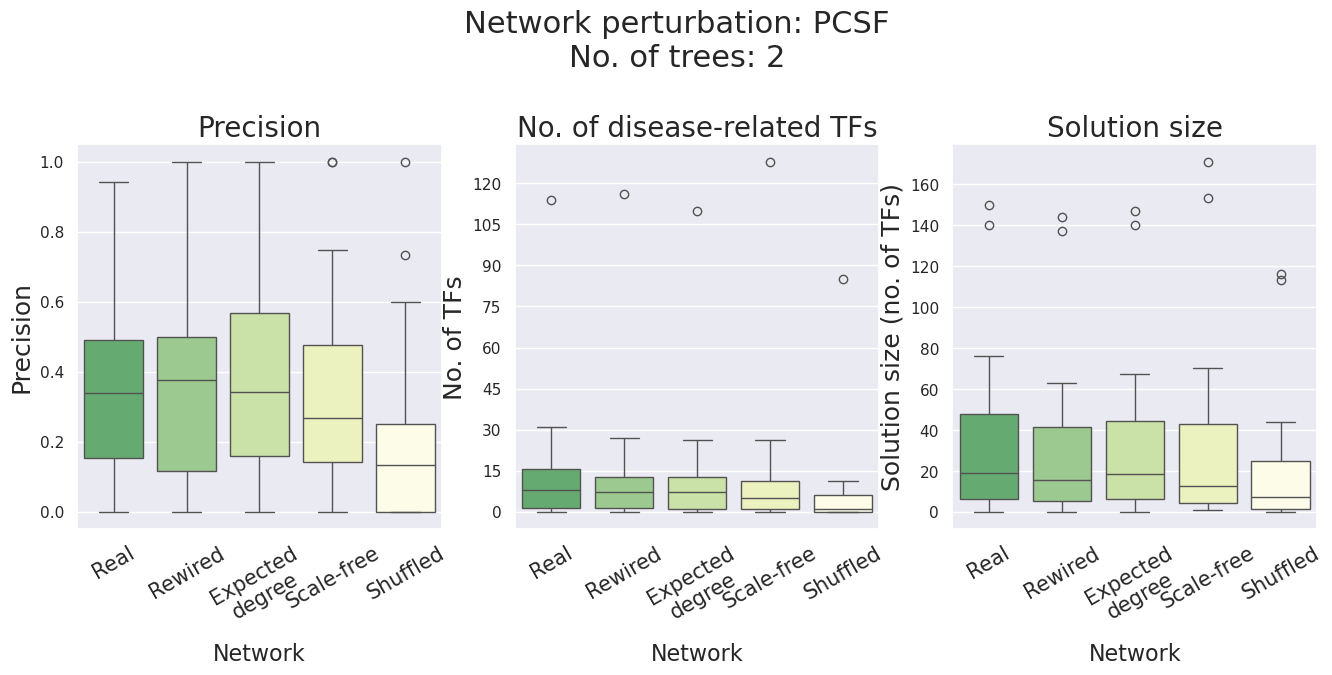

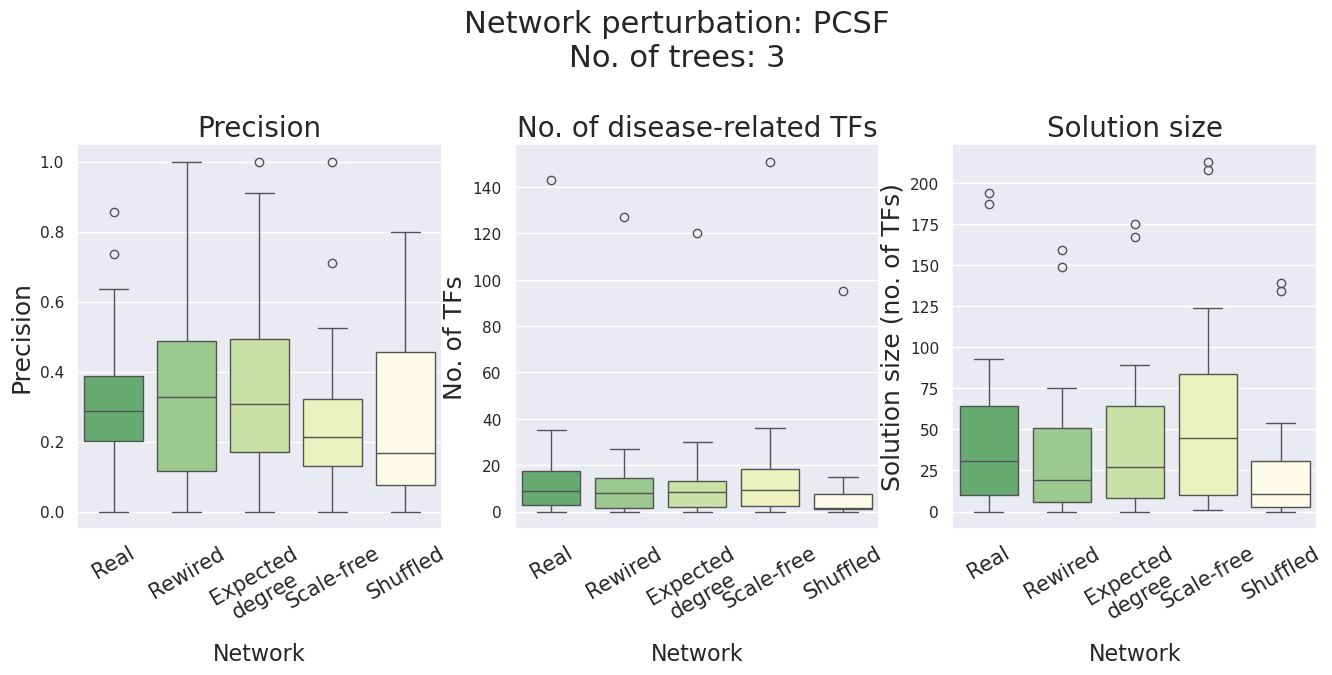

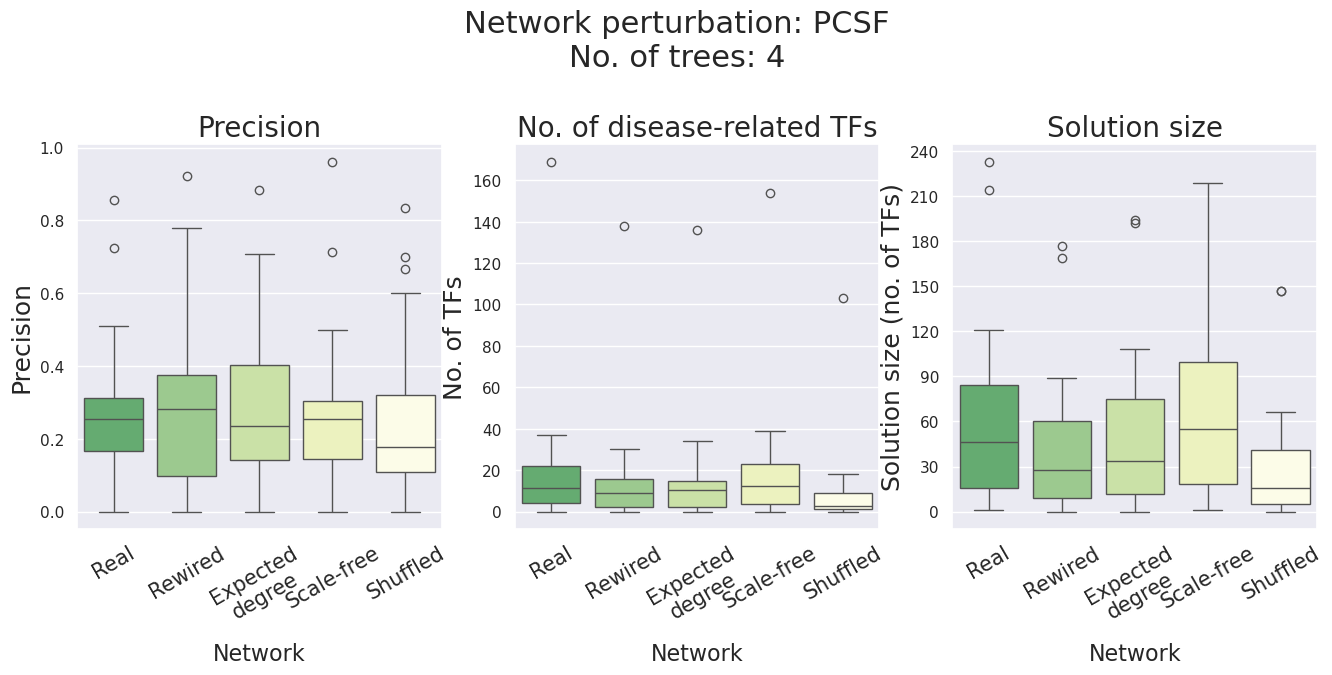

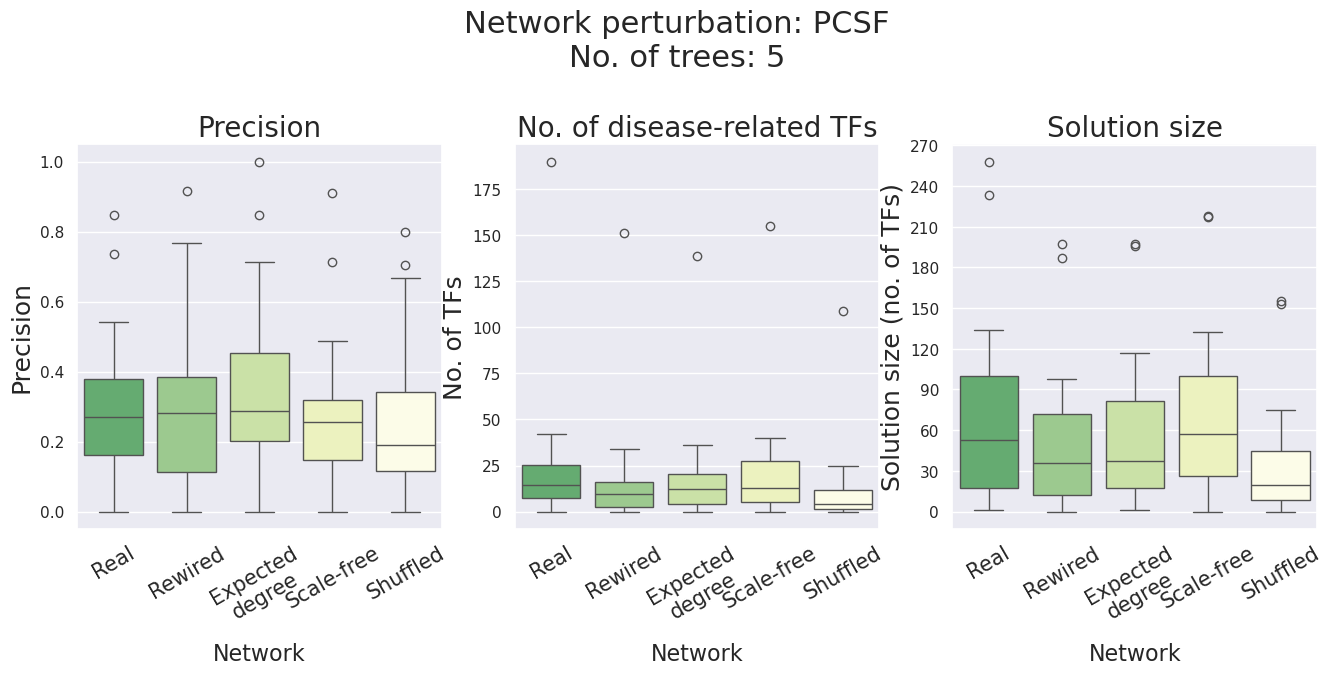

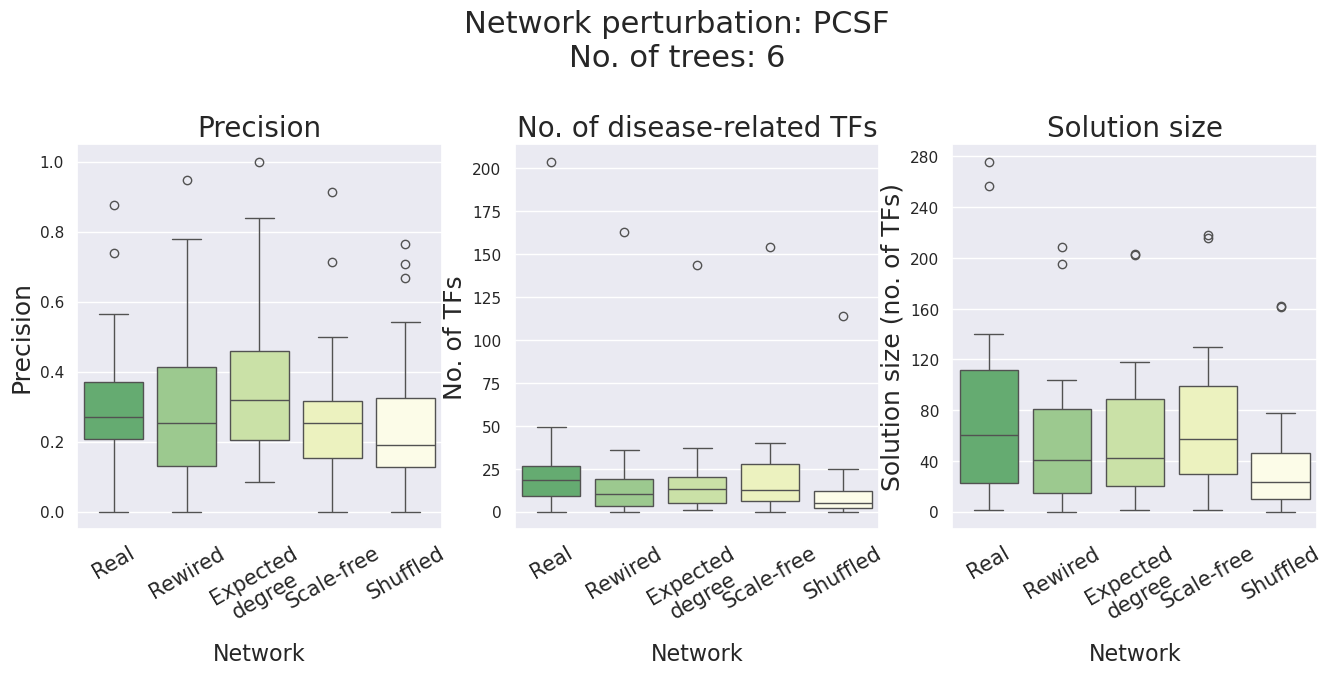

In [32]:
folder_pcsf_extri_all = r"/data2/home/giga/TRIPS_results/ZENODO/EXTRI/results_pcsf/2/"

n_mechanisms = [2,3,4,5,6]
target_workflow = "pcsf"

for n_mech in n_mechanisms:

    title = "Network perturbation: PCSF\nNo. of trees: {}".format(n_mech)
    dict_precision, dict_recall, dict_soln_size = network_perturbation(folder_pcsf_extri_all, target_workflow, all_datasets, all_tfs=all_tfs,
                                                                          dict_dataset_map=dict_dataset_map, folder_degs=folder_degs, 
                                                                          title=title, gold_standard=dict_disease_genes_min1, n_mech=n_mech)
    
    new_labels = ["Real","Rewired","Expected\ndegree", "Scale-free","Shuffled"]
    title = "Network perturbation: PCSF\nNo. of trees: {}".format(n_mech)

    filename = os.path.join(figures_folder_extri, "network_perturbation_pcsf_multip2_nmech{}.svg".format(n_mech))
    generate_plot(dict_precision, dict_recall, dict_soln_size, target_workflow="pcsf",
                  title=title, new_labels=new_labels, 
                 filename=filename, figsize=(16,5), y=1.15,
                 size_xticklabel=15, size_ylabel=18, size_xlabel=16,
                 xlabel = "Network", size_subtitle=20, my_colors=colors_pcsf, rotation=30)

## Network perturbation: MOGAMUN

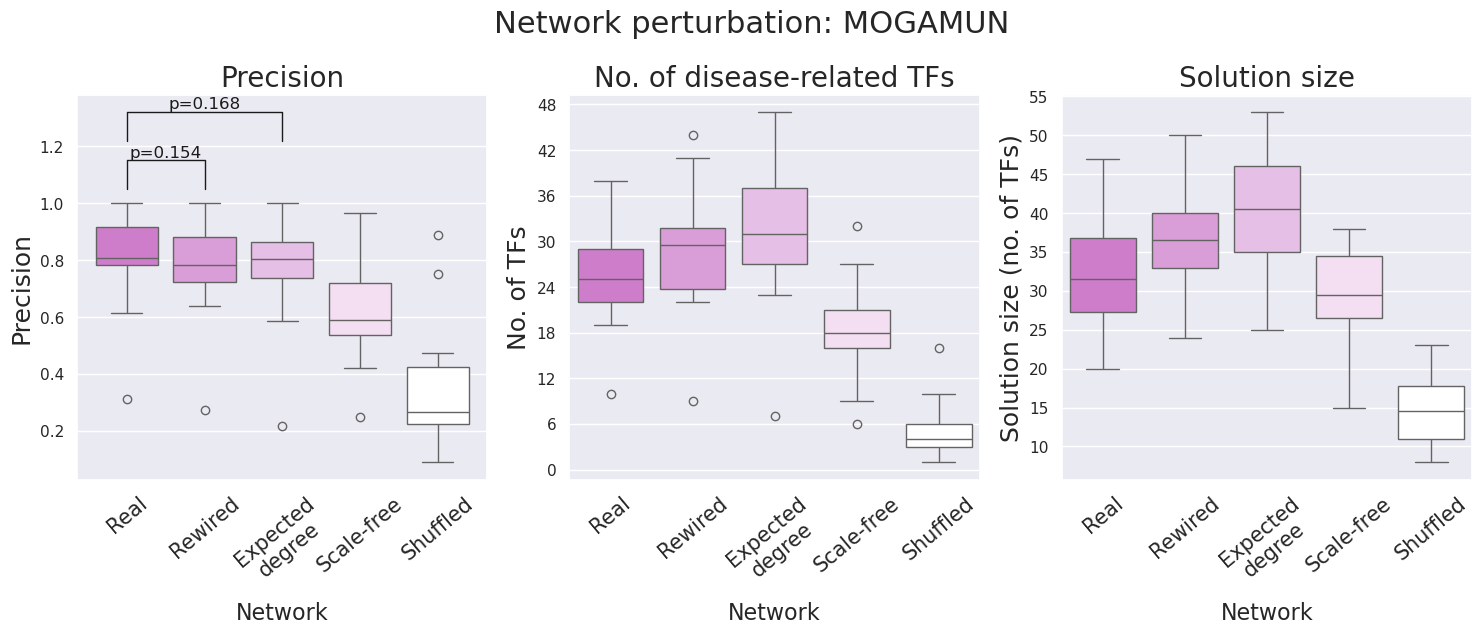

In [33]:
target_workflow = "mogamun"

folder_mogamun_all = r"/data2/home/giga/TRIPS_results/ZENODO/EXTRI/results_mogamun"
title = "Network perturbation: MOGAMUN"
dict_precision, dict_recall, dict_soln_size = network_perturbation(folder_mogamun_all, target_workflow, all_datasets, all_tfs=all_tfs, 
                                                                      dict_dataset_map=dict_dataset_map, folder_degs=folder_degs, 
                                                                      title=title, gold_standard=dict_disease_genes_min1)

new_labels = ["Real","Rewired","Expected\ndegree", "Scale-free","Shuffled"]

filename = os.path.join(figures_folder_extri, "network_perturbation_mogamun.svg")
generate_plot_compare(dict_precision, dict_recall, dict_soln_size, target_workflow = "mogamun",
              title=title, new_labels=new_labels, 
             filename=filename, figsize=(18,5), y=1.05,
             size_xticklabel=15, size_ylabel=18, size_xlabel=16,
             xlabel = "Network", size_subtitle=20, my_colors=colors_mogamun, rotation=40)